In [39]:
import pandas as pd
import pyreadstat as prs
import numpy as np
pd.set_option('display.max_colwidth', None)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

import re

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip

from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV
from numpy import arange

# Data ingestion and manipulation

In [40]:
relesco = pd.read_csv('C:\\Users\\alevizos.i\\Downloads\\ESCO dataset - v1.1.1 - classification - en - csv\\broaderRelationsSkillPillar_en.csv')
relesco = relesco.rename(columns={"conceptUri": "narrow", "broaderUri": "broad"})

In [41]:
relesco.groupby(['conceptType','broaderType']).count()

narrow  broad
conceptType              broaderType                            
KnowledgeSkillCompetence KnowledgeSkillCompetence    6565   6565
                         SkillGroup                 13448  13448
SkillGroup               SkillGroup                   643    643

In [42]:
skh = pd.read_csv('C:\\Users\\alevizos.i\\Downloads\\ESCO dataset - v1.1.1 - classification - en - csv\\skillsHierarchy_en.csv')
skh = skh[skh['Level 0 URI'].str.startswith("http")]

In [43]:
digiesco = pd.read_csv('C:\\Users\\alevizos.i\\Downloads\\ESCO dataset - v1.1.1 - classification - en - csv\\digitalSkillsCollection_en.csv')
digiesco = pd.concat([digiesco, digiesco['broaderConceptUri'].str.split("|", -1, expand = True)], axis=1 )
digiesco = pd.melt(digiesco, id_vars=['conceptUri', 'broaderConceptUri'], value_vars=[0, 1, 2,3,4,5,6], var_name='useless', value_name='broaderUriDigi')

In [44]:
digibroad_list = list(digiesco['broaderUriDigi'].unique())
diginarrow_list = list(digiesco['conceptUri'].unique())

In [45]:
digibroad = relesco[relesco['broad'].isin(digibroad_list)]

In [46]:
n_digi_dii = pd.DataFrame(diginarrow_list, columns = ["skill"])
n_digi_dii['dii'] = 1

In [47]:
digibroad1 = pd.merge(digibroad, digiesco, left_on="narrow", right_on="conceptUri", how="left")
digibroad1['dii'] = np.where(digibroad1['conceptUri'].isna(), 0, 1)
digidii = digibroad1.groupby('broad').mean().reset_index().rename(columns = {'broad': 'skill'})

In [48]:
total_dii = pd.concat([n_digi_dii,digidii])

In [49]:
lev3_skills = skh['Level 3 URI'].dropna().reset_index().rename(columns = {"Level 3 URI": "level3"})
lev3_skills = lev3_skills.drop_duplicates(subset = ['level3'])
l3indir = lev3_skills[~lev3_skills['level3'].isin(total_dii['skill'])]

l3dii = pd.DataFrame(columns = ['skill','dii'])
for i in l3indir['level3']:
    l3broad = relesco[relesco['broad']==i]
    l31 = pd.merge(l3broad, total_dii, left_on="narrow", right_on="skill", how="left")
    l31['dii'] = l31['dii'].fillna(0)
    digidii = l31.groupby('broad').mean().reset_index().rename(columns = {'broad': 'skill'})
    l3dii = pd.concat([l3dii,digidii])
total_dii = pd.concat([total_dii,l3dii])

In [50]:
lev2_skills = skh['Level 2 URI'].dropna().reset_index().rename(columns = {"Level 2 URI": "level2"})
lev2_skills = lev2_skills.drop_duplicates(subset = ['level2'])

l2indir = lev2_skills[~lev2_skills['level2'].isin(total_dii['skill'])]

l2dii = pd.DataFrame(columns = ['skill','dii'])
for i in l2indir['level2']:
    l2broad = relesco[relesco['broad']==i]
    l21 = pd.merge(l2broad, total_dii, left_on="narrow", right_on="skill", how="left")
    l21['dii'] = l21['dii'].fillna(0)
    digidii = l21.groupby('broad').mean().reset_index().rename(columns = {'broad': 'skill'})
    l2dii = pd.concat([l2dii,digidii])
total_dii = pd.concat([total_dii,l2dii])

In [51]:
lev1_skills = skh['Level 1 URI'].dropna().reset_index().rename(columns = {"Level 1 URI": "level1"})
lev1_skills = lev1_skills.drop_duplicates(subset = ['level1'])

l1indir = lev1_skills[~lev1_skills['level1'].isin(total_dii['skill'])]

l1dii = pd.DataFrame(columns = ['skill','dii'])
for i in l1indir['level1']:
    l1broad = relesco[relesco['broad']==i]
    l11 = pd.merge(l1broad, total_dii, left_on="narrow", right_on="skill", how="left")
    l11
    l11['dii'] = l11['dii'].fillna(0)
    digidii = l11.groupby('broad').mean().reset_index().rename(columns = {'broad': 'skill'})
    l1dii = pd.concat([l1dii,digidii])
total_dii = pd.concat([total_dii,l1dii])

In [52]:
lev0_skills = skh['Level 0 URI'].dropna().reset_index().rename(columns = {"Level 0 URI": "level0"})
lev0_skills = lev0_skills.drop_duplicates(subset = ['level0'])

l0indir = lev0_skills[~lev0_skills['level0'].isin(total_dii['skill'])]

l0dii = pd.DataFrame(columns = ['skill','dii'])
for i in l0indir['level0']:
    l0broad = relesco[relesco['broad']==i]
    l01 = pd.merge(l0broad, total_dii, left_on="narrow", right_on="skill", how="left")
    l01['dii'] = l01['dii'].fillna(0)
    digidii = l01.groupby('broad').mean().reset_index().rename(columns = {'broad': 'skill'})
    l0dii = pd.concat([l0dii,digidii])
total_dii = pd.concat([total_dii,l0dii])

In [53]:
testdii0 = pd.merge(total_dii, skh, left_on = 'skill', right_on = 'Level 0 URI').drop_duplicates(subset=['Level 0 URI'])
testdii0 = testdii0[['skill','dii','Level 0 preferred term']].rename(columns = {'Level 0 preferred term':'name'})

testdii1 = pd.merge(total_dii, skh, left_on = 'skill', right_on = 'Level 1 URI').drop_duplicates(subset=['Level 1 URI'])
testdii1 = testdii1[['skill','dii','Level 1 preferred term']].rename(columns = {'Level 1 preferred term':'name'})
testdii2 = pd.merge(total_dii, skh, left_on = 'skill', right_on = 'Level 2 URI').drop_duplicates(subset=['Level 2 URI'])
testdii2 = testdii2[['skill','dii','Level 2 preferred term']].rename(columns = {'Level 2 preferred term':'name'})
testdii3 = pd.merge(total_dii, skh, left_on = 'skill', right_on = 'Level 3 URI').drop_duplicates(subset=['Level 3 URI'])
testdii3 = testdii3[['skill','dii','Level 3 preferred term']].rename(columns = {'Level 3 preferred term':'name'})
ytest_final_dii = pd.concat([testdii0,testdii1,testdii2,testdii3])

In [54]:
complete_dii = ytest_final_dii.reset_index(drop=True)
#complete_dii.to_csv("Digital Index Complete List.csv", index=False)

In [55]:
complete_dii = complete_dii.sort_values('dii', ascending = False).drop_duplicates('name', keep='first')

In [56]:
complete_dii.sort_values('name')

skill  \
493  http://data.europa.eu/esco/skill/8369011d-de43-4800-bcce-be12e19828a5   
80   http://data.europa.eu/esco/skill/28d2ab6c-38a2-476e-85fe-7982fd242943   
462  http://data.europa.eu/esco/skill/00d5d1d2-c521-4c58-9df5-2939c0ce9adb   
195                                http://data.europa.eu/esco/isced-f/0411   
118  http://data.europa.eu/esco/skill/24ad2ffb-dece-4704-8155-63ea9428d038   
477  http://data.europa.eu/esco/skill/b036eb5c-6a48-45b9-b2c6-f42f9e336204   
479  http://data.europa.eu/esco/skill/eb6cc4ba-4bb8-4348-9a3b-dc419558f66a   
476  http://data.europa.eu/esco/skill/8c298a9b-e9ea-4396-897d-9aba982df6a0   
471  http://data.europa.eu/esco/skill/062a9fde-cd91-44f9-9a2f-9e2bc3b281fd   
480  http://data.europa.eu/esco/skill/efbb3d3b-a41c-4e0a-90a8-8e611eb1db9f   
475  http://data.europa.eu/esco/skill/62afcfdd-a2a6-4143-bafb-59c77e15a01c   
472  http://data.europa.eu/esco/skill/08104c27-d4b2-4d40-ae97-dde65e71712f   
225  http://data.europa.eu/esco/skill/0a4c5823-8b09-4e6b-95b4-8036ef3b9c4c   
171                                 http://data.europa.eu/esco/isced-f/081   
28                                   http://data.europa.eu/esco/isced-f/08   
176                                 http://data.europa.eu/esco/isced-f/089   
170                                 http://data.europa.eu/esco/isced-f/080   
411  http://data.europa.eu/esco/skill/f73c2c9e-b097-4fcb-95d1-659ea0bd54a3   
410  http://data.europa.eu/esco/skill/92fc9726-5b5e-439e-a33c-06a8c63fbb9a   
235  http://data.europa.eu/esco/skill/1f2950c0-ef1e-44b4-9a55-125ccd7b78af   
307  http://data.europa.eu/esco/skill/ec528c47-65f4-4187-9dc1-5a8889f84a06   
370  http://data.europa.eu/esco/skill/d94e1143-3a3a-4f6a-a881-df93bf56cf23   
287  http://data.europa.eu/esco/skill/ba1f6201-b206-4459-b178-706db34a851d   
45   http://data.europa.eu/esco/skill/d6e97b91-b75d-45f5-8566-667798957b0f   
42   http://data.europa.eu/esco/skill/6115ff80-3d84-4e87-8e2b-6ede7ee004b4   
43   http://data.europa.eu/esco/skill/6c6957bf-cf1f-4483-9c7e-1655f251b01a   
44   http://data.europa.eu/esco/skill/80cf002a-6586-4db7-9c9a-88325a9a5e1b   
41   http://data.europa.eu/esco/skill/44ff6716-7d71-4a16-821b-61d10e9e290d   
40   http://data.europa.eu/esco/skill/3d54fec5-d9cb-45a0-bf8d-ffaf3790a5bb   
397  http://data.europa.eu/esco/skill/da230865-9d2a-42d9-a42e-37d89753109e   
395  http://data.europa.eu/esco/skill/5ea47148-5289-49f2-80f8-bb1f54b37de0   
398  http://data.europa.eu/esco/skill/e6e784d0-38a2-4f0c-9fe9-d985a3269fd9   
167                                 http://data.europa.eu/esco/isced-f/073   
551                                http://data.europa.eu/esco/isced-f/0731   
481  http://data.europa.eu/esco/skill/1072f444-8a7d-41c1-aa6f-d536f20d94bf   
140                                 http://data.europa.eu/esco/isced-f/021   
22                                   http://data.europa.eu/esco/isced-f/02   
144                                 http://data.europa.eu/esco/isced-f/029   
139                                 http://data.europa.eu/esco/isced-f/020   
65   http://data.europa.eu/esco/skill/b8e142fe-e508-42b1-b037-efebcefac3a7   
250  http://data.europa.eu/esco/skill/592525ab-b517-4c55-8c65-17e0f5d99205   
338  http://data.europa.eu/esco/skill/62023d5b-22ea-442e-ac46-39eb83c986fb   
340  http://data.europa.eu/esco/skill/bd1242ec-6dd5-4c7d-bf79-8de6be3b3815   
369  http://data.europa.eu/esco/skill/3eef7ff2-3ade-41d4-b084-2bd2a3949e1c   
407  http://data.europa.eu/esco/skill/bffa732b-12ab-4214-a4b3-498598820b1c   
18   http://data.europa.eu/esco/skill/c73521be-c039-4e22-b037-3b01b3f6f9d9   
490  http://data.europa.eu/esco/skill/173fbafb-d2e0-4b89-be1c-548b1cc47160   
451  http://data.europa.eu/esco/skill/29fbde52-e525-4653-96d0-acd59ccb28d8   
467  http://data.europa.eu/esco/skill/8826b057-0e80-4e3d-9efc-1e179d597f40   
466  http://data.europa.eu/esco/skill/77ee8fad-188f-44cf-88ba-4e495a52d604   
191                                http://data.europa.eu/esco/isced-f/0211   
133          

### Map DII to Skills- Occupation Tables

In [57]:
occu_skills = pd.read_excel('C:\\Users\\alevizos.i\\Downloads\\skills_occupations_matrix_tables (2).xlsx', sheet_name=None, header = 1)

In [58]:
skills3x2 = occu_skills.get('Matrix 3.2')
skills3x2 = skills3x2.rename(columns={"Unnamed: 1": "Occupation", "Unnamed: 0": "Job Link"})
skills3x2flat = pd.melt(skills3x2, id_vars=list(skills3x2.columns)[0:2], value_vars=list(skills3x2.columns)[2:], var_name='skill', value_name='association')
skills3x2flat = pd.merge(skills3x2flat, testdii3, left_on='skill',right_on='name', how='left')
skills3x2flat['dii'] = pd.to_numeric(skills3x2flat['dii'])
skills3x2flat['digi2'] = skills3x2flat['dii']*skills3x2flat['association']
skills3x2flat = skills3x2flat.groupby(['Job Link','Occupation']).mean().reset_index()[['Job Link','Occupation','digi2']]
skills3x2flat['Job Code2'] = skills3x2flat['Job Link'].str[-2:]

In [59]:
skills3x3 = occu_skills.get('Matrix 3.3')
skills3x3 = skills3x3.rename(columns={"Unnamed: 1": "Occupation", "Unnamed: 0": "Job Link"})
skills3x3flat = pd.melt(skills3x3, id_vars=list(skills3x3.columns)[0:2], value_vars=list(skills3x3.columns)[2:], var_name='skill', value_name='association')
skills3x3flat = pd.merge(skills3x3flat, testdii3, left_on='skill',right_on='name', how='left')
skills3x3flat['dii'] = pd.to_numeric(skills3x3flat['dii'])
skills3x3flat['digi3'] = skills3x3flat['dii']*skills3x3flat['association']
skills3x3flat = skills3x3flat.groupby(['Job Link','Occupation']).mean().reset_index()[['Job Link','Occupation','digi3']]
skills3x3flat['Job Code3'] = skills3x3flat['Job Link'].str[-3:]

In [60]:
skills3x4 = occu_skills.get('Matrix 3.4')
skills3x4 = skills3x4.rename(columns={"Unnamed: 1": "Occupation", "Unnamed: 0": "Job Link"})
skills3x4flat = pd.melt(skills3x4, id_vars=list(skills3x4.columns)[0:2], value_vars=list(skills3x4.columns)[2:], var_name='skill', value_name='association')
skills3x4flat = pd.merge(skills3x4flat, testdii3, left_on='skill',right_on='name', how='left')
skills3x4flat['digi'] = skills3x4flat['dii']*skills3x4flat['association']
skills3x4flat['dii'] = pd.to_numeric(skills3x4flat['dii'])
skills3x4flat['digi4'] = skills3x4flat['dii']*skills3x4flat['association']
skills3x4flat = skills3x4flat.groupby(['Job Link','Occupation']).mean().reset_index()[['Job Link','Occupation','digi4']]
skills3x4flat['Job Code4'] = skills3x4flat['Job Link'].str[-4:]

### Calculate Sectors' TII

In [61]:
rnd_isic = pd.read_csv('C:\\Users\\alevizos.i\\Downloads\\Sector Technological intensity - OECD RnD.csv', sep=';')

In [62]:
multi_isic = pd.read_csv('C:\\Users\\alevizos.i\\Downloads\\ISIC Sector Intensity Index - 2018 multifactor approach.csv',sep=';')

In [63]:
aggr_isic = pd.merge(rnd_isic,multi_isic, on='Sector', how = 'outer')

In [64]:
aggr_isic['tii_x'] = aggr_isic['tii_x'].fillna(aggr_isic['tii_y'])
aggr_isic['tii_y'] = aggr_isic['tii_y'].fillna(aggr_isic['tii_x'])

In [65]:
aggr_isic['tii1-1'] = (aggr_isic['tii_x']+aggr_isic['tii_y'])/2
aggr_isic['tii1-5'] = (aggr_isic['tii_x']+5*aggr_isic['tii_y'])/6
aggr_isic = aggr_isic.rename(columns={'tii_x':'tii_rnd','tii_y':'tii_multi'})

In [66]:
isic_desc = pd.read_excel('C:\\Users\\alevizos.i\\Downloads\\ISIC.xlsx', sheet_name='ISIC_Rev_4', header = 0)

In [67]:
isic_desc = isic_desc[['division','division_label']].drop_duplicates()
isic_ttl = pd.merge(aggr_isic,isic_desc,left_on='Sector', right_on = 'division', how='left')

In [68]:
isic_ttl.to_csv("Complete Technological Intensity Index.csv", index=False)

### Transforming ISCED Data

In [69]:
isced_dii = complete_dii[complete_dii['skill'].str.startswith("http://data.europa.eu/esco/isced-f/")].sort_values(by='name')
isced_dii['skill_id'] = isced_dii['skill'].str.split("f/",expand=False)
isced_dii['skill_id'] = isced_dii['skill_id'].str[1]
isced_dii['skill_group'] = isced_dii['skill_id'].str[0:2]
isced_dii = isced_dii[isced_dii['skill_id'].str.len()==4]
isced_dii['skill_group'] = isced_dii['skill_group'].replace({'04': '03', '05': '04','06': '04','07':'05', '08': '06','09': '07','10':'08'})
isced_dii['skill_group'][isced_dii['skill_id']=='0712'] = '08'
isced_dii['skill_group'][isced_dii['skill_id']=='0522'] = '06'
isced_dii_g = isced_dii.groupby('skill_group').mean()['dii'].reset_index()
isced_dii_g['Group Name'] = isced_dii_g['skill_group']
isced_dii_g['Group Name'] = isced_dii_g['Group Name'].replace({'00': 'General programmes', \
                                                               '01': 'Teacher training and education science',\
                                                               '02': 'Humanities, languages and arts ', \
                                                               '03': 'Social sciences, business and law', \
                                                               '04': 'Science, mathematics and computing', \
                                                               '05': 'Engineering, manufacturing and construction',\
                                                               '06': 'Agriculture and veterinary',\
                                                               '07': 'Health and welfare',\
                                                               '08': 'Services'})
isced_dii_g['isced_dii'] = isced_dii_g['dii'].round(4)
isced_dii_g['skill_group'] = isced_dii_g['skill_group'].astype(int)
isced_dii_g['skill_group_adj'] = isced_dii_g['skill_group']+1


### Reading PIAAC Data

In [70]:
import gc
gc.collect()

957

In [71]:
# %reset

In [72]:
def get_values(column):
    ret = meta.variable_value_labels.get(column)
    return ret

def get_variable_desc(df, total_cols):
    tc = pd.DataFrame(columns = ['var','desc'])
    for i in total_cols:
        try: 
            desc = meta.column_names_to_labels[i]
        except:
            desc = ''
        tc.loc[len(tc)] = [i, desc]
    return tc

In [73]:
chk, meta = prs.read_sav('C:/Users/alevizos.i/Downloads/prggrcp1.sav')
#chk = chk.fillna(-100)

In [187]:
meta.column_names_to_labels['tii1-5'] = 'Occupational Domain Technical Intensity (R&D significance 1/6)'
meta.column_names_to_labels['tii1-1'] = 'Occupational Domain Technical Intensity (R&D significance 1/2)'
meta.column_names_to_labels['isced_dii'] = 'Educational Domain Digital Intensity'
meta.column_names_to_labels['digi2'] = '2-digit ISCO Group Digital Intensity'
meta.column_names_to_labels['digi4'] = '4-digit ISCO Group Digital Intensity'

In [188]:
#We filter data based in th eexistance of home & work activity tasks. This is done due to OECD's instructions on PIAAC, 
# that additional imputation is not intende for null values; this will be our bse approach

ictvars = ['LEARNATWORK',
'READYTOLEARN',
'ICTHOME',
'ICTWORK',
'INFLUENCE',
'NUMHOME',
'NUMWORK',
'PLANNING',
'READHOME',
'READWORK',
'TASKDISC',
'WRITHOME',
'WRITWORK']

#mask = (~chk[ictvars].isna().any(axis=1))
#employed.loc[mask, workictvars] = 0

final = chk.dropna(subset=ictvars)

In [189]:
final = final.dropna(subset=['PVPSL1'])

In [190]:
#We proceed to check what working status each remaining individual has, in order to ensure everyone is coded as employed 

#  final.groupby('C_D05', dropna = False).count()['CNTRYID']

In [191]:
#For cases where a foreign degree has been acquired, we add this value to the initial column

final['B_Q01a'] = np.where(final['B_Q01a']==15, final['B_Q01a3'] , final['B_Q01a'])
#display(final[['B_Q01a','B_Q01a3']].drop_duplicates())

In [192]:
#Let's examine how respondents' are split among areas of studies

#  final.groupby(['B_Q01b','B_Q01a'], dropna = False).count()['CNTRYID'].reset_index().sort_values(by='B_Q01a')

In [193]:
# We will proceed with a left join on ISCED-F, so that we can replace the field of study with its respective DII

# Since ISCED-F values in PIAAC are coded as ISCED+1, we will proceed to replace nulls with 1s ,as General programs
# We will only apply this to levels below ISCED-4, since tehy are the basic training
# It makes sense to impute 1 values to them, since they also hold 0 DII on the ISCED-F side
# Afterwards, we remove remaining nulls with ISCED level 4 or above

In [194]:
mask = ((final['B_Q01a']<4) & (final['B_Q01b'].isna()))
#final[mask]
final['B_Q01b'] = np.where(((final['B_Q01a']<4) & (final['B_Q01b'].isna())), 1 , final['B_Q01b'])
final = pd.merge(final, isced_dii_g, left_on='B_Q01b',right_on = 'skill_group_adj', how = 'left')
final.groupby(['B_Q01b','skill_group'], dropna = False).count()['CNTRYID'].reset_index()

final = final.dropna(subset='B_Q01b')

In [195]:
#  final.groupby(['B_Q01b','skill_group_adj'], dropna = False).count()['CNTRYID'].reset_index()

In [196]:
# 9996 is a valid skip code. In cases of unemployed individuals, ISCO2C and ISCO08_C will be 9996, since their last job
# is coded under ISCO02L,ISCO08_L fields. As such, we will proceed to replace 9996 with the _L corresponding codes to bring all
# occupational info to a single column
final['ISCO08_C'] = np.where(final['ISCO2C']=='9996', final['ISCO08_L'] , final['ISCO08_C'])
final['ISCO2C'] = np.where(final['ISCO2C']=='9996', final['ISCO2L'] , final['ISCO2C'])

#While 9995 is a valid code for not paid jobs, these jobs still enclose a technical intensity.
#Since the ISCO-08 column has the actual occupation of the respondents, we'll proceed to map their first 2 digits to ISCO2

final['ISCO2C'] = np.where(final['ISCO2C']=='9995', final['ISCO08_C'].str[0:2] , final['ISCO2C'])
final = pd.merge(final, skills3x4flat[['digi4','Job Code4']], left_on = 'ISCO08_C', right_on = 'Job Code4', how = 'left')
final = pd.merge(final, skills3x2flat[['digi2','Job Code2']], left_on = 'ISCO2C', right_on = 'Job Code2', how = 'left')


In [197]:
#final = final.drop(columns = ['digi4_x','Job Code4_x','digi4_y','Job Code4_y', 'digi2_x','Job Code2_x','digi2_y','Job Code2_y'])

In [198]:
# We follow thw 9995 mapper here as well.
#IMPORTANT NOTE: The shift of ISIC column from str to int is done for performance purposes
#HOWEVER, this is only possible due tot he limit of ISIC sector to 2-digit. In any other case, it would be required
#to retain str format, since the preceding 0s are of importance. 3-digit 011 as an int, would be 
final['ISIC4_C'] = np.where(final['ISIC4_C']=='9996', final['ISIC4_L'] , final['ISIC4_C'])
final['ISIC2C'] = np.where(final['ISIC2C']=='9996', final['ISIC2L'] , final['ISIC2C'])

final['ISIC2C'] = np.where(final['ISIC2C']=='9995', final['ISIC4_C'].str[0:2] , final['ISIC2C'])

final['ISIC2C'] = final['ISIC2C'].astype(int)

In [199]:
final = pd.merge(final, aggr_isic[['Sector','tii1-1','tii1-5']], left_on = 'ISIC2C', right_on = 'Sector', how = 'left')

In [200]:
import re


pattern = r'[FGHI]_Q0\d[a-zA-Z]?$'
activity_cols = [item for item in chk.columns if re.match(pattern, item)]

In [201]:
get_variable_desc(final, meta.column_names_to_labels)

var  \
0                       CNTRYID   
1                     CNTRYID_E   
2                         SEQID   
3                         AGE_R   
4                      GENDER_R   
5                     DISP_CIBQ   
6                     DISP_MAIN   
7                  DISP_MAINWRC   
8                       A_N01_T   
9                        B_Q01a   
10                     B_Q01a_T   
11                      B_Q01a3   
12                    B_Q01a3_C   
13                       B_Q01b   
14                      B_Q01c1   
15                    B_Q01c1_C   
16                    B_Q01c1_T   
17                      B_Q01c2   
18                       B_Q01d   
19                       B_D01d   
20                     B_D01d_C   
21                       B_Q02a   
22                    B_Q02a_T1   
23                    B_Q02a_T2   
24                       B_Q02b   
25                     B_Q02b_C   
26                       B_Q02c   
27                       B_Q03a   
28                       B_Q03b   
29                     B_Q03b_C   
30                      B_Q03c1   
31                    B_Q03c1_C   
32                      B_Q03c2   
33                       B_Q03d   
34                       B_D03d   
35                     B_D03d_C   
36                       B_Q04a   
37                       B_Q04b   
38                     B_Q04b_C   
39                       B_Q05a   
40                       B_Q05b   
41                       B_Q05c   
42                     B_Q05c_T   
43                       B_Q10a   
44                       B_Q10b   
45                       B_Q10c   
46                        B_Q11   
47                       B_Q12a   
48                     B_Q12a_T   
49                       B_Q12b   
50                       B_Q12c   
51                       B_Q12d   
52                     B_Q12d_C   
53                       B_Q12e   
54                       B_Q12f   
55                     B_Q12f_C   
56                       B_Q12g   
57                       B_Q12h   
58                     B_Q12h_C   
59                       B_D12h   
60                        B_Q13   
61                       B_Q14a   
62                       B_Q14b   
63                       B_Q15a   
64                       B_Q15b   
65                       B_Q15c   
66                        B_Q16   
67                        B_Q17   
68                       B_Q18a   
69                       B_Q19a   
70                       B_Q20a   
71                       B_Q20b   
72                       B_Q26a   
73                     B_Q26a_T   
74                       B_Q26b   
75                       C_Q01a   
76                       C_Q01b   
77                       C_Q01c   
78                       C_Q02a   
79                       C_Q02b   
80                       C_Q02c   
81                     C_Q03_01   
82                     C_Q03_02   
83                     C_Q03_03   
84                     C_Q03_04   
85                     C_Q03_05   
86                     C_Q03_06   
87                     C_Q03_07   
88                     C_Q03_08   
89                     C_Q03_09   
90                     C_Q03_10   
91                        C_S03   
92                       C_Q04a   
93                       C_Q04b   
94                       C_Q04c   
95                       C_Q04d   
96                       C_Q04e   
97                       C_Q04f   
98                       C_Q04g   
99                       C_Q04h   
100                      C_Q04i   
101                      C_Q04j   
102                       C_D04   
103                       C_Q05   
104                       C_D05   
105                       C_Q06   
106                       C_D06   
107                       C_Q07   
108                     C_Q07_T   
109                      C_Q08a   
110                      C_Q08b   
111                     C_Q08c1   
112                   C_Q08c1_C   
113                     C_Q08c2   
114

In [202]:
rest_cols = ['C_Q01a','C_Q01b','C_Q01c','FE12','B_Q05c','NFE12','NFE12JR', 'NFE12NJR','isced_dii','tii1-1','tii1-5','digi2','digi4']
total_cols = activity_cols.copy()
for i in rest_cols:
    total_cols.append(i)
for i in ictvars:
    total_cols.append(i)
total_cols.append('PVPSL1')
total_cols.append('SPFWT0')
total_cols.append('B_Q01a')

In [203]:
#We want to make sure no nulls are included in our dataset, and as such we proceed to examine the possible cases

In [204]:
# We find multiple nulls in C_Q01b, C_Q01c. This is expected, since a positive answer to the question series (a-b-c)
# routes the respondent to another section, leaving tailing questions empty.
#However, the columns are not of interest for the analysis, rather than control factors during our processing, so we remove them
# We also remove H_Q04a & b, since after examination all people are currently using PC
to_remove = ['C_Q01a','C_Q01b','C_Q01c','H_Q04a','H_Q04b']
final = final.drop(columns = to_remove)
for i in to_remove:  
    total_cols.remove(i)
#We do not see any strange occupation allocation for the F_Q07 null respondents, and we have no other way to derive a probable value
# As such, we will proceed to drop those responses

#display(final[final['F_Q07a'].isnull()])

final = final.dropna(subset=['F_Q07a'])

# We replace NaNs and 2s in B_Q05c with 0s. This is to reframe the data as 'having completed JR formal', which means that
# non-jr and no P12M training provide the same result (done in the absesne of a derived meatric capturing this)

final['B_Q05c'] =  final['B_Q05c'].fillna(0)
final['B_Q05c'] = final['B_Q05c'].replace(2,0)




In [205]:
# # We only need responses that have been populated with PValues. We could impute 0s to respondents who have no PVs due to 
# # literacy or ICT usage insufficiency, but we attempt to provide the determinants for cases where are applicable

# pattern1 = r'PVPS.*'

# search  = [item for item in final.columns if re.match(pattern1, item)]
# search
# ftest = final.dropna(subset = search)

In [206]:
final = final.dropna(subset=total_cols)
len(final)

538

In [207]:
# repetitions1 = final[['SPFWT0', 'SEQID']]
# repetitions1['we'] = repetitions['SPFWT0']/min(final['SPFWT0'])

In [208]:
sum(final['SPFWT0'])

732741.7732393139

In [209]:
repetitions = final['SPFWT0']/min(final['SPFWT0'])
# When the division results in float, we round up or down based on the first decimal point
repetitions = np.where(repetitions % 1 < 0.5, np.floor(repetitions), np.ceil(repetitions))
#Let's check what percentage of weighted population we're missing by our rounding
w1 = sum(final['SPFWT0'])
w2 = sum(repetitions)*min(final['SPFWT0'])
(w2 -w1)/w1*100

0.04623245132290138

In [210]:
sum(repetitions)

6517.0

In [211]:
# Repeat each column based on 'x2' values
trial = pd.concat([final.loc[final.index.repeat(repetitions)].reset_index(drop=True) for _, final in final.iteritems()], axis=1)

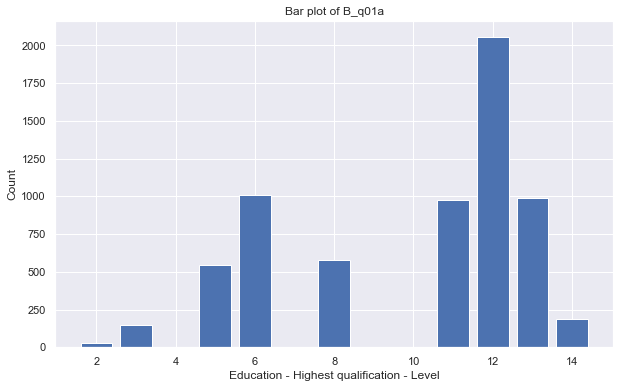

In [212]:
import matplotlib.pyplot as plt

# Assuming 'trial' is your DataFrame and 'B_q01a' is your column
counts = trial['B_Q01a'].value_counts()
plot = trial.groupby('B_Q01a').count()['CNTRYID'].reset_index()
plot
plt.figure(figsize=(10,6))
plt.bar(plot['B_Q01a'], plot['CNTRYID'])
plt.xlabel(meta.column_names_to_labels['B_Q01a'])
plt.ylabel('Count')
plt.title('Bar plot of B_q01a')
plt.show()

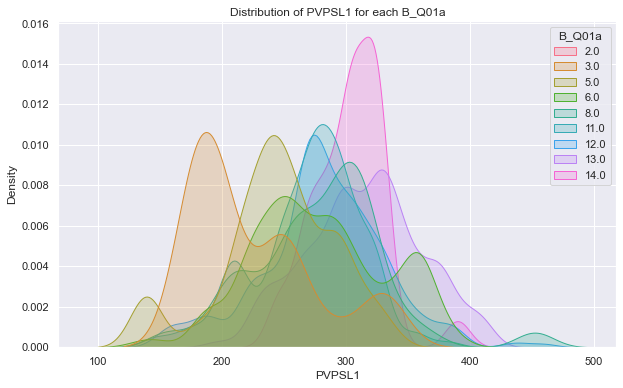

In [213]:
palette = sns.color_palette("husl", len(trial['B_Q01a'].unique()))

plt.figure(figsize=(10, 6))
sns.kdeplot(data=trial, x="PVPSL1", hue="B_Q01a", fill=True, palette=palette,common_norm=False)

plt.title('Distribution of PVPSL1 for each B_Q01a')
plt.xlabel('PVPSL1')
plt.ylabel('Density')
plt.show()

In [214]:
# g = sns.FacetGrid(trial, col="B_Q01a", col_wrap=4, height=4, aspect=1)

# # Map a kdeplot onto each facet
# g.map(sns.kdeplot, "PVPSL1", fill=True)

# # Add x and y axis labels to each subplot
# g.set_axis_labels("PVPSL1", "Density")

# # Show the plot
# plt.show()

In [229]:
get_values('G_Q04')

{1.0: 'Yes',
 2.0: 'No',
 6.0: 'Valid skip',
 7.0: "Don't know",
 8.0: 'Refused',
 9.0: 'Not stated or inferred'}

In [374]:
total_reg = total_cols.copy()
total_reg.remove('PVPSL1')
total_reg.remove('SPFWT0')
total_reg.remove('G_Q04')
tc = get_variable_desc(trial, total_reg)
tc

var  \
0          F_Q01b   
1          F_Q02a   
2          F_Q02b   
3          F_Q02c   
4          F_Q02d   
5          F_Q02e   
6          F_Q03a   
7          F_Q03b   
8          F_Q03c   
9          F_Q04a   
10         F_Q04b   
11         F_Q05a   
12         F_Q05b   
13         F_Q06b   
14         F_Q06c   
15         F_Q07a   
16         F_Q07b   
17         G_Q01a   
18         G_Q01b   
19         G_Q01c   
20         G_Q01d   
21         G_Q01e   
22         G_Q01f   
23         G_Q01g   
24         G_Q01h   
25         G_Q02a   
26         G_Q02b   
27         G_Q02c   
28         G_Q02d   
29         G_Q03b   
30         G_Q03c   
31         G_Q03d   
32         G_Q03f   
33         G_Q03g   
34         G_Q03h   
35         G_Q05a   
36         G_Q05c   
37         G_Q05d   
38         G_Q05e   
39         G_Q05f   
40         G_Q05g   
41         G_Q05h   
42          G_Q06   
43          G_Q07   
44          G_Q08   
45         H_Q01a   
46         H_Q01b   
47         H_Q01c   
48         H_Q01d   
49         H_Q01e   
50         H_Q01f   
51         H_Q01g   
52         H_Q01h   
53         H_Q02a   
54         H_Q02b   
55         H_Q02c   
56         H_Q02d   
57         H_Q03b   
58         H_Q03c   
59         H_Q03d   
60         H_Q03f   
61         H_Q03g   
62         H_Q03h   
63         H_Q05a   
64         H_Q05c   
65         H_Q05d   
66         H_Q05e   
67         H_Q05f   
68         H_Q05g   
69         H_Q05h   
70         I_Q04b   
71         I_Q04d   
72         I_Q04h   
73         I_Q04j   
74         I_Q04l   
75         I_Q04m   
76         I_Q05f   
77         I_Q06a   
78         I_Q07a   
79         I_Q07b   
80          I_Q08   
81           FE12   
82         B_Q05c   
83          NFE12   
84        NFE12JR   
85       NFE12NJR   
86      isced_dii   
87         tii1-1   
88         tii1-5   
89          digi2   
90          digi4   
91    LEARNATWORK   
92   READYTOLEARN   
93        ICTHOME   
94        ICTWORK   
95      INFLUENCE   
96        NUMHOME   
97        NUMWORK   
98       PLANNING   
99       READHOME   
100      READWORK   
101      TASKDISC   
102      WRITHOME   
103      WRITWORK   
104        B_Q01a   

                                                                                                         desc  
0                                                           Skill use work - Time cooperating with co-workers  
1                                                      Skill use work - How often - Sharing work-related info  
2                                                                Skill use work - How often - Teaching people  
3                                                                  Skill use work - How often - Presentations  
4                                                                        Skill use work - How often - Selling  
5                                                                Skill use work - How often - Advising people  
6                                                        Skill use work - How often - Planning own activities  
7                                                     Skill use work - How often - Planning others activities  
8                                                            Skill use work - How often - Organising own time  
9                                                             Skill use work - How often - Influencing people  
10                                                       Skill use work - How often - Negotiating with people  
11                                                         Skill use work - Problem solving - Simple problems  
12                                                        Skill use work - Problem solving - Complex problems  
13                                            Skill use work - How often - Working physically for long period  
14                                                        Skill use work - How often - Using hands or finge

In [375]:
plain_reg = [i for i in activity_cols if i in total_reg]
comp_reg = [i for i in total_reg if i not in activity_cols]

main_cols = ['isced_dii','tii1-1','tii1-5','digi2','digi4','FE12','B_Q05c','NFE12','NFE12JR','NFE12NJR','B_Q01a']
for i in main_cols:
    plain_reg.append(i)

In [426]:
# We obviously have existing collinearities.
# We will run pairwise comparison on our collinear variables, retaining the ones that have the best explainability on their own

def univar_reg_explore(df,cols):
    unilist = []
    model = LinearRegression()
    y = np.array(df['PVPSL1']).reshape(-1,1)
    y = normalize(y, axis=0)

    l = len(df)
    for i in cols:
        try:
            x = np.array(df[i]).reshape(-1,1)
            x = normalize(x, axis=0)
            x = sm.add_constant(x)
            
            result = sm.OLS(y, x).fit(cov_type = 'HC3')
            x_co = result.params[1]
            pvs = result.pvalues[1].round(4)
            bs = result.bse[1]
            unilist.append([i ,result.rsquared_adj,bs,  x_co, pvs])

            print(result.summary())

        except Exception as e:
            #print(f"{i} is not included in the dataset, skipping to the next predictor")
            print(e)
            continue
    unidf = pd.DataFrame(unilist,columns = ['Variable','R', 'Std Error','Coef', 'P > |z|'])
    return unidf

In [427]:
unidf3 = univar_reg_explore(trial,total_reg)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     25.25
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           5.17e-07
Time:                        01:36:30   Log-Likelihood:                 30410.
No. Observations:                6517   AIC:                        -6.082e+04
Df Residuals:                    6515   BIC:                        -6.080e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0126   8.48e-05    148.234      0.0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     312.2
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           2.78e-68
Time:                        01:36:31   Log-Likelihood:                 30547.
No. Observations:                6517   AIC:                        -6.109e+04
Df Residuals:                    6515   BIC:                        -6.108e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0113   5.78e-05    195.999      0.0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     66.00
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           5.35e-16
Time:                        01:36:31   Log-Likelihood:                 30427.
No. Observations:                6517   AIC:                        -6.085e+04
Df Residuals:                    6515   BIC:                        -6.084e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0117      6e-05    195.554      0.0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     24.11
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           9.34e-07
Time:                        01:36:31   Log-Likelihood:                 30409.
No. Observations:                6517   AIC:                        -6.081e+04
Df Residuals:                    6515   BIC:                        -6.080e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0128      0.000     97.821      0.0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.188
Date:                Sat, 04 Nov 2023   Prob (F-statistic):              0.139
Time:                        01:36:31   Log-Likelihood:                 30398.
No. Observations:                6517   AIC:                        -6.079e+04
Df Residuals:                    6515   BIC:                        -6.078e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0123   6.68e-05    183.655      0.0

In [428]:
totaluni = unidf3[((unidf3['P > |z|'] < 0.05) & (unidf3['R'] > 0.001))].sort_values(by='R', ascending = False).reset_index(drop = True)
tn = list(totaluni['Variable'])
totaluni['Description'] = get_variable_desc(trial, tn)['desc']
totaluni.to_csv("complete_univatiate.csv")
negaun = unidf3[((unidf3['P > |z|'] < 0.05) & (unidf3['R'] > 0.001) & (unidf3['Coef'] < 0))].sort_values(by='R', ascending = False).reset_index(drop = True)
nn = list(negaun['Variable'])
negaun['Description'] = get_variable_desc(trial, nn)['desc']

negaun.to_csv("negative_univatiate.csv")

PermissionError: [Errno 13] Permission denied: 'negative_univatiate.csv'

In [ ]:
# plt.figure(figsize=(10, 6))

# sns.set (style = 'darkgrid')
# sns.scatterplot (trial, y='PVPSL1',x='G_Q05g')
# plt.title ('Coefficient - Explanatory Power')
# plt.ylabel ('Score')
# plt.xlabel ('G_Q05g')
# plt.show ()

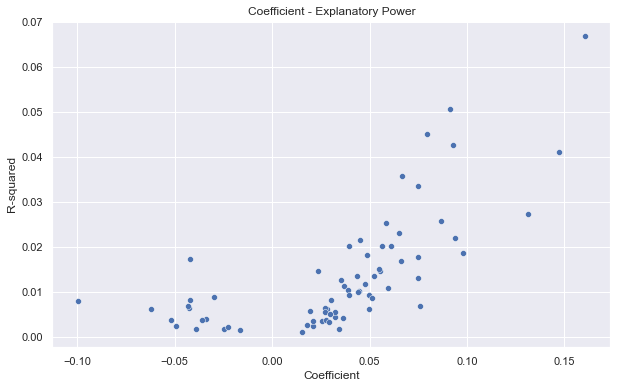

In [382]:
plt.figure(figsize=(10, 6))

sns.set (style = 'darkgrid')
sns.scatterplot (unidf3[(unidf3['P > |z|'] < 0.005)], y='R',x='Coef')
plt.title ('Coefficient - Explanatory Power')
plt.ylabel ('R-squared')
plt.xlabel ('Coefficient')
plt.show ()

In [383]:
# We create a function which calculates which columns need be removed due to high collinearity
#We only need to provide the df on which the calculation will be conducted on, 
# the columns it will consider, and the collinearity threshold
# It returns a list of string with the variables that whould be removed

def corel_cleaner(final, first_reg, thresh):  
    corel = final[first_reg].corr()
    corel = corel.reset_index()
    corel =  pd.melt(corel, id_vars=['index'], value_vars=corel.columns[1:], var_name='attribute', value_name='correlation')
    corel['correlation'] = corel['correlation'].astype('float')
    high_corel = corel[(corel['correlation']>thresh) & (corel['correlation']<1)]

    high_corel = pd.merge(high_corel,unidf3, left_on='index',right_on='Variable')
    high_corel = pd.merge(high_corel,unidf3, left_on='attribute',right_on='Variable')
    high_corel = high_corel.rename(columns={"R_x": "index_R", "R_y": "attribute_R"})
    high_corel = high_corel.reset_index(drop = True)
    high_corel['remove'] = np.where(high_corel['index_R'] > high_corel['attribute_R'], high_corel['attribute'] , high_corel['index'])
    high_corel = high_corel.drop_duplicates(subset=['remove'])
    display(high_corel[['index','attribute','index_R','attribute_R','remove']])
    removal_list = list(high_corel['remove'].unique())
    return removal_list
    

In [385]:
#We remove the correlated column with the lowest adj_r^2 for each pair comparing all columns

crtrial_t = corel_cleaner(trial,total_reg,0.8)

for i in crtrial_t:
    print(i)
    try:
        total_reg.remove(i)
    except Exception as e:
        print(e)


Empty DataFrame
Columns: [index, attribute, index_R, attribute_R, remove]
Index: []

In [387]:
#We replicate for plain and composite column sets. 
#We do that cause in case that a pair includes one plain and one composite column, the sub-datasets shouldn't be affected


crtrial_p = corel_cleaner(trial,plain_reg,0.8)
for i in crtrial_p:
    print(i)
    try:
        plain_reg.remove(i)
    except Exception as e:
        print(e)
        
crtrial_c = corel_cleaner(trial,comp_reg,0.8)
for i in crtrial_p:
    print(i)
    try:
        comp_reg.remove(i)
    except Exception as e:
        print(e)

Empty DataFrame
Columns: [index, attribute, index_R, attribute_R, remove]
Index: []

Empty DataFrame
Columns: [index, attribute, index_R, attribute_R, remove]
Index: []

In [388]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def multi_reg_explore(df,cols):
    unilist = []
    model = LinearRegression()
    y = np.array(df['PVPSL1']).reshape(-1,1)
    y = normalize(y, axis=0)

    l = len(df)
    for i in cols:
        x = np.array(df[i]).reshape(-1,len(i))
        x = sm.add_constant(x)
        x = normalize(x, axis=0)


        result = sm.OLS(y, x).fit(cov_type = 'HC3')
        x_co = result.params
        pvs = result.pvalues[1].round(4)
        coef_df = pd.DataFrame(columns = ['Coef'], data = x_co.reshape(-1,1))
        coef_df['p'] = result.pvalues.round(4)
        coef_nam = []
        if((len(result.params))>len(i)):
           coef_nam.append('Intercept')
        for j in i:
           coef_nam.append(j)
        coef_df['Variable'] = coef_nam
        print(result.summary(xname=coef_nam))
        vif =     pd.Series([variance_inflation_factor(x, i) for i in range(x.shape[1])], index=coef_nam)

    return coef_df, result.rsquared_adj, vif

In [491]:
def multi_reg_explore2(df,cols):
    unilist = []
    model = LinearRegression()
    y = np.array(df['PVPSL1']).reshape(-1,1)
    y = normalize(y, axis=0)

    l = len(df)
    for i in cols:
        x = np.array(df[i]).reshape(-1,len(i))
        x = sm.add_constant(x)
        x = normalize(x, axis=0)


        result = sm.OLS(y, x).fit(cov_type = 'HC3')
        x_co = result.params
        pvs = result.pvalues[1].round(4)
        coef_df = pd.DataFrame(columns = ['Coef'], data = x_co.reshape(-1,1))
        coef_df['p'] = result.pvalues.round(4)
        coef_df['std error'] = result.bse
        coef_nam = []
        if((len(result.params))>len(i)):
           coef_nam.append('Intercept')
        for j in i:
           coef_nam.append(j)
        coef_df['Variable'] = coef_nam
        print(result.summary(xname=coef_nam))

    return coef_df, result.rsquared_adj

In [655]:
def multi_reg_explore3(df,cols):
    unilist = []
    model = LinearRegression()
    y = np.array(df['PVPSL1']).reshape(-1,1)
    y = normalize(y, axis=0)

    l = len(df)
    for i in cols:
        x = np.array(df[i]).reshape(-1,len(i))
        x = sm.add_constant(x)
        x = normalize(x, axis=0)
        X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)
        x = X_train
        y = y_train



        result = sm.OLS(y, x).fit(cov_type = 'HC3')
        x_co = result.params
        pvs = result.pvalues[1].round(4)
        coef_df = pd.DataFrame(columns = ['Coef'], data = x_co.reshape(-1,1))
        coef_df['p'] = result.pvalues.round(4)
        coef_df['std error'] = result.bse
        coef_nam = []
        if((len(result.params))>len(i)):
           coef_nam.append('Intercept')
        for j in i:
           coef_nam.append(j)
        coef_df['Variable'] = coef_nam
        print(result.summary(xname=coef_nam))
        vif =     pd.Series([variance_inflation_factor(x, i) for i in range(x.shape[1])], index=coef_nam)
    from statsmodels.tools.eval_measures import rmse

    ypred = result.predict(X_test)
    rmse = rmse(y_test, ypred)
    return rmse

In [657]:
max(multi_reg_explore3(trial, [total_reg]))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     54.77
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:14:30   Log-Likelihood:                 24254.
No. Observations:                4887   AIC:                        -4.831e+04
Df Residuals:                    4788   BIC:                        -4.767e+04
Df Model:                          98                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9253      0.065     14.167   

0.004848145540952853

In [515]:
# Here we compare the f statistic based on two models

multi_reg_explore3(trial,[total_reg]).compare_f_test(multi_reg_explore3(trial,[total_regf]))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     71.26
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:20:36   Log-Likelihood:                 32287.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6418   BIC:                        -6.371e+04
Df Model:                          98                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9410      0.057     16.548   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     80.58
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:20:45   Log-Likelihood:                 32241.
No. Observations:                6517   AIC:                        -6.434e+04
Df Residuals:                    6446   BIC:                        -6.386e+04
Df Model:                          70                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0952      0.035     31.154   

(3.274793085363633, 1.2725213725236473e-08, 28.0)

In [519]:
final_complete = multi_reg_explore2(trial,[total_reg])
final_complete = final_complete[0]
final_complete['abs'] = abs(final_complete['coef'])
final_complete.sort_values(by = 'abs')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     71.26
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:24:00   Log-Likelihood:                 32287.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6418   BIC:                        -6.371e+04
Df Model:                          98                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9410      0.057     16.548   

TypeError: tuple indices must be integers or slices, not str

In [532]:
final_complete['abs'] = abs(final_complete['Coef'])
final_complete = final_complete[final_complete['Variable']!='Intercept']
final_complete.sort_values(by = 'abs', ascending = False).reset_index(drop = True)

Coef       p  std error      Variable       abs           var  \
0   0.167181  0.0000   0.015853        I_Q04b  0.167181        I_Q04b   
1  -0.156728  0.0000   0.014181        H_Q02a  0.156728        H_Q02a   
2   0.136293  0.0000   0.011799      WRITHOME  0.136293      WRITHOME   
3  -0.134132  0.0000   0.017754  READYTOLEARN  0.134132  READYTOLEARN   
4  -0.128778  0.0000   0.017244        I_Q04m  0.128778        I_Q04m   
5  -0.123147  0.0000   0.011315        G_Q05a  0.123147        G_Q05a   
6   0.123125  0.0000   0.020972        H_Q01b  0.123125        H_Q01b   
7  -0.117360  0.0003   0.032169       ICTHOME  0.117360       ICTHOME   
8  -0.113597  0.0210   0.049204      READHOME  0.113597      READHOME   
9  -0.103233  0.0000   0.010478        F_Q03a  0.103233        F_Q03a   
10  0.101703  0.0000   0.008693        B_Q01a  0.101703        B_Q01a   
11  0.101589  0.0000   0.018134       NUMHOME  0.101589       NUMHOME   
12  0.101398  0.0000   0.014861        H_Q05c  0.101398        H_Q05c   
13  0.099640  0.0000   0.010343        G_Q02a  0.099640        G_Q02a   
14  0.098196  0.0001   0.025857       NUMWORK  0.098196       NUMWORK   
15 -0.089238  0.0000   0.010424        F_Q02a  0.089238        F_Q02a   
16  0.088521  0.0000   0.013214        H_Q05f  0.088521        H_Q05f   
17  0.081575  0.0000   0.008100        I_Q06a  0.081575        I_Q06a   
18  0.080431  0.0000   0.018270        I_Q04d  0.080431        I_Q04d   
19 -0.076660  0.0000   0.018416        I_Q04h  0.076660        I_Q04h   
20 -0.070038  0.0000   0.011417        G_Q01b  0.070038        G_Q01b   
21 -0.066722  0.0000   0.009713         G_Q06  0.066722         G_Q06   
22 -0.065534  0.0000   0.009084        H_Q02d  0.065534        H_Q02d   
23 -0.065082  0.0642   0.035159     INFLUENCE  0.065082     INFLUENCE   
24  0.062823  0.0000   0.008619        F_Q02b  0.062823        F_Q02b   
25  0.060964  0.0000   0.009466        H_Q01h  0.060964        H_Q01h   
26 -0.059069  0.0000   0.005766        G_Q01e  0.059069        G_Q01e   
27 -0.058857  0.0000   0.009041        G_Q03h  0.058857        G_Q03h   
28  0.057698  0.0000   0.008053        G_Q01a  0.057698        G_Q01a   
29 -0.057279  0.0000   0.010437        F_Q03c  0.057279        F_Q03c   
30 -0.056549  0.0000   0.009802      WRITWORK  0.056549      WRITWORK   
31  0.053046  0.0000   0.006099   LEARNATWORK  0.053046   LEARNATWORK   
32 -0.050498  0.0000   0.007519        G_Q01f  0.050498        G_Q01f   
33 -0.049414  0.0000   0.011655        G_Q03d  0.049414        G_Q03d   
34 -0.048567  0.0000   0.010802        F_Q07a  0.048567        F_Q07a   
35  0.047581  0.0000   0.005957        F_Q06c  0.047581        F_Q06c   
36  0.043062  0.0000   0.010492        F_Q04b  0.043062        F_Q04b   
37  0.042845  0.0000   0.007260        H_Q01e  0.042845        H_Q01e   
38 -0.041737  0.0000   0.007062        G_Q03g  0.041737        G_Q03g   
39  0.041607  0.0001   0.010901        H_Q01d  0.041607        H_Q01d   
40 -0.041284  0.0000   0.006708        F_Q01b  0.041284        F_Q01b   
41  0.040914  0.0003   0.011424      PLANNING  0.040914      PLANNING   
42  0.040487  0.0002   0.010868        H_Q05e  0.040487        H_Q05e   
43  0.039863  0.0000   0.007101        H_Q05d  0.039863        H_Q05d   
44 -0.039538  0.0000   0.006288         I_Q08  0.039538         I_Q08   
45 -0.038317  0.0000   0.004443        F_Q06b  0.038317        F_Q06b   
46  0.038069  0.0000   0.007135        H_Q05g  0.038069        H_Q05g   
47  0.036682  0.0000   0.006435        I_Q07b  0.036682        I_Q07b   
48 -0.035817  0.0001   0.009017        H_Q03d  0.035817        H_Q03d   
49  0.034594  0.0000   0.005852        G_Q01h  0.034594        G_Q01h   
50  0.034533  0.0384   0.016679        I_Q04j  0.034533        I_Q04j   
51  0.033614  0.1209   0.021672        H_Q05a  0.033614        H_Q05a   
52  0.033360  0.0000   0.007465        F_Q02c  0.033360        F_Q02c   
53  0.032104  0.0071   0.011928        G_Q03c  0.032104        G_Q

In [531]:
final_complete = pd.merge(final_complete,get_variable_desc(trial,total_reg), left_on = 'Variable', right_on = 'var')

In [389]:
# tt1 = total_cols.remove('PVPSL1')
# tt1 = total_cols.remove('SPFWT0')
multi_plain, plain_r, vif = multi_reg_explore(trial,[plain_reg])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     65.81
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:24:55   Log-Likelihood:                 32131.
No. Observations:                6517   AIC:                        -6.408e+04
Df Residuals:                    6428   BIC:                        -6.348e+04
Df Model:                          88                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1662      0.037     31.176      0.0

In [497]:
multi_total, total_r = multi_reg_explore2(trial,[total_reg])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     71.26
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:38:20   Log-Likelihood:                 32287.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6418   BIC:                        -6.371e+04
Df Model:                          98                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9410      0.057     16.548   

In [329]:
multi_plain['abs_coef'] = abs(multi_plain['Coef'])
multi_plain[multi_plain['Coef'] != 0 ].sort_values(by = 'abs_coef', ascending = False)

Coef       p   Variable  abs_coef
0   1.166200  0.0000  Intercept  1.166200
76 -0.160725  0.0000     I_Q04m  0.160725
71  0.125946  0.0000     I_Q04b  0.125946
36 -0.124370  0.0000     G_Q05a  0.124370
88  0.108036  0.0000     B_Q01a  0.108036
47  0.105400  0.0000     H_Q01b  0.105400
75 -0.101604  0.0000     I_Q04l  0.101604
73 -0.099438  0.0000     I_Q04h  0.099438
78  0.088518  0.0000     I_Q06a  0.088518
16 -0.074983  0.0000     F_Q07a  0.074983
7  -0.074526  0.0000     F_Q03a  0.074526
65  0.072514  0.0000     H_Q05c  0.072514
31  0.069077  0.0000     G_Q03c  0.069077
43 -0.066808  0.0000      G_Q06  0.066808
26  0.066074  0.0000     G_Q02a  0.066074
2  -0.062594  0.0000     F_Q02a  0.062594
19 -0.058832  0.0000     G_Q01b  0.058832
54 -0.055937  0.0000     H_Q02a  0.055937
51 -0.055455  0.0000     H_Q01f  0.055455
18  0.054313  0.0000     G_Q01a  0.054313
3   0.051973  0.0000     F_Q02b  0.051973
9  -0.049892  0.0000     F_Q03c  0.049892
22 -0.049500  0.0000     G_Q01e  0.049500
20  0.049330  0.0000     G_Q01c  0.049330
81 -0.048635  0.0000      I_Q08  0.048635
15  0.048540  0.0000     F_Q06c  0.048540
48 -0.047276  0.0000     H_Q01c  0.047276
53  0.047217  0.0000     H_Q01h  0.047217
68  0.046173  0.0000     H_Q05f  0.046173
28 -0.044270  0.0000     G_Q02c  0.044270
23 -0.038382  0.0000     G_Q01f  0.038382
25  0.037980  0.0000     G_Q01h  0.037980
14 -0.037732  0.0000     F_Q06b  0.037732
30  0.037384  0.0000     G_Q03b  0.037384
35 -0.035864  0.0000     G_Q03h  0.035864
59  0.034988  0.0000     H_Q03c  0.034988
1  -0.034573  0.0000     F_Q01b  0.034573
38  0.034147  0.0000     G_Q05d  0.034147
5  -0.032111  0.0000     F_Q02d  0.032111
11  0.031967  0.0000     F_Q04b  0.031967
84  0.030168  0.0000      digi4  0.030168
80  0.030025  0.0000     I_Q07b  0.030025
29 -0.029381  0.0000     G_Q02d  0.029381
32 -0.029320  0.0030     G_Q03d  0.029320
42 -0.027557  0.0000     G_Q05h  0.027557
50  0.027316  0.0000     H_Q01e  0.027316
37 -0.026721  0.0007     G_Q05c  0.026721
8   0.026400  0.0000     F_Q03b  0.026400
66  0.026164  0.0000     H_Q05d  0.026164
69  0.025361  0.0000     H_Q05g  0.025361
64 -0.024276  0.0875     H_Q05a  0.024276
4   0.023709  0.0000     F_Q02c  0.023709
49  0.023655  0.0001     H_Q01d  0.023655
33  0.023489  0.0001     G_Q03f  0.023489
24 -0.023388  0.0008     G_Q01g  0.023388
45 -0.022207  0.0322      G_Q08  0.022207
86  0.019096  0.0000      NFE12  0.019096
6   0.018889  0.0006     F_Q02e  0.018889
52  0.017760  0.0108     H_Q01g  0.017760
34 -0.017536  0.0019     G_Q03g  0.017536
70  0.015196  0.0002     H_Q05h  0.015196
41 -0.015151  0.0007     G_Q05g  0.015151
40 -0.015098  0.0594     G_Q05f  0.015098
27 -0.014978  0.0016     G_Q02b  0.014978
85 -0.014262  0.0000     B_Q05c  0.014262
17  0.013018  0.0751     F_Q07b  0.013018
87  0.012638  0.0000   NFE12NJR  0.012638
57  0.011915  0.0526     H_Q02d  0.011915
83  0.011099  0.0282     tii1-5  0.011099
56  0.009179  0.1217     H_Q02c  0.009179
61 -0.008471  0.1110     H_Q03f  0.008471
12  0.008268  0.4526     F_Q05a  0.008268
10 -0.007199  0.3425     F_Q04a  0.007199
60 -0.006846  0.3457     H_Q03d  0.006846
74 -0.006359  0.6170     I_Q04j  0.006359
62 -0.005772  0.2403     H_Q03g  0.005772
21 -0.005488  0.4606     G_Q01d  0.005488
13 -0.005330  0.4588     F_Q05b  0.005330
82  0.005195  0.2694  isced_dii  0.005195
46 -0.004249  0.4717     H_Q01a  0.004249
77  0.003939  0.3632     I_Q05f  0.003939
44  0.003176  0.7537      G_Q07  0.003176
67  0.003113  0.6167     H_Q05e  0.003113
55 -0.003095  0.4968     H_Q02b  0.003095
72  0.001855  0.9115     I_Q04d  0.001855
58 -0.001724  0.7907     H_Q03b  0.001724
39  0.001654  0.8072     G_Q05e  0.001654
63  0.001404  0.7859     H_Q03h  0.001404
79 -0.000326  0.9605     I_Q07a  0.000326

In [390]:
def signifizer (df, tester, collist):
    cll = collist.copy()
    deleted = []
    try:
        cll.remove('G_Q04')
    except Exception as e:
        
        print(e)
    flag = True
    while flag:
        flag = False
        mp = max(tester['p'])
        if mp > 0.005:
            tester, recent_r, vifr = multi_reg_explore(df,[cll])
            flag = True
            try:
                todel = list(tester['Variable'][tester['p']==mp])[0]
                print(todel)
                deleted.append(todel)
                cll.remove(todel)
                for i in range(1, len(vifr)):
                    if vifr[i] > 10:
                        print("EEEEEEEEEEE")
                        print(vifr.index[i])
                        deleted.append(vifr.index[i])
                        
                        cll.remove(vifr.index[i])

            except Exception as e:
                print(e)
    print(deleted)
    return tester, cll, recent_r

In [513]:
def signifizer2 (df, tester, collist):
    cll = collist.copy()
    deleted = []
    try:
        cll.remove('G_Q04')
    except Exception as e:
        
        print(e)
    flag = True
    while flag:
        flag = False
        mp = max(tester['p'])
        if mp > 0.005:
            # need to add vifr as an variable below as well receiving output
            tester, recent_r = multi_reg_explore2(df,[cll])
            flag = True
            try:
                todel = list(tester['Variable'][tester['p']==mp])[0]
                print(todel)
                deleted.append(todel)
                cll.remove(todel)

            except Exception as e:
                print(e)
    for i in range(1, len(vifr)):
        if vifr[i] > 10:
            print("EEEEEEEEEEE")
            print(vifr.index[i])
            deleted.append(vifr.index[i])

            cll.remove(vifr.index[i])
    tester, recent_r= multi_reg_explore2(df,[cll])
    print(deleted)
    return tester, cll, recent_r #, vifr

In [514]:
multi_totalf, total_regf, total_r = signifizer2(trial,multi_total,total_reg)

multi_totalf['abs_coef'] = abs(multi_totalf2['Coef'])
multi_totalf1 = multi_totalf[multi_totalf['Variable']!='Intercept']
multi_totalf1 = pd.merge(multi_totalf1, get_variable_desc(multi_totalf1, total_regf), left_on='Variable',right_on ='var')
multi_totalf1.sort_values(by ='abs_coef', ascending = False).reset_index(drop = True)
#multi_totalf1.to_csv("significant multi.csv")
multi_totalf1.sort_values(by ='abs_coef', ascending = False).reset_index(drop = True)

list.remove(x): x not in list
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     71.26
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:25   Log-Likelihood:                 32287.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6418   BIC:                        -6.371e+04
Df Model:                          98                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     71.71
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:25   Log-Likelihood:                 32287.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6419   BIC:                        -6.371e+04
Df Model:                          97                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9416      0.057     16.636   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     71.71
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:26   Log-Likelihood:                 32287.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6419   BIC:                        -6.371e+04
Df Model:                          97                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9416      0.057     16.636   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     70.67
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:26   Log-Likelihood:                 32287.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6420   BIC:                        -6.372e+04
Df Model:                          96                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9432      0.056     16.804   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     70.67
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:26   Log-Likelihood:                 32287.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6420   BIC:                        -6.372e+04
Df Model:                          96                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9432      0.056     16.804   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     71.11
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:27   Log-Likelihood:                 32287.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6421   BIC:                        -6.373e+04
Df Model:                          95                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9470      0.056     16.885   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     71.11
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:27   Log-Likelihood:                 32287.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6421   BIC:                        -6.373e+04
Df Model:                          95                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9470      0.056     16.885   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     71.73
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:27   Log-Likelihood:                 32286.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6422   BIC:                        -6.374e+04
Df Model:                          94                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9463      0.056     16.874   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     71.73
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:28   Log-Likelihood:                 32286.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6422   BIC:                        -6.374e+04
Df Model:                          94                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9463      0.056     16.874   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     71.94
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:28   Log-Likelihood:                 32286.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6423   BIC:                        -6.375e+04
Df Model:                          93                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9465      0.056     16.881   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     71.94
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:28   Log-Likelihood:                 32286.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6423   BIC:                        -6.375e+04
Df Model:                          93                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9465      0.056     16.881   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     72.01
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:29   Log-Likelihood:                 32285.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6424   BIC:                        -6.375e+04
Df Model:                          92                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9549      0.054     17.539   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     72.01
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:29   Log-Likelihood:                 32285.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6424   BIC:                        -6.375e+04
Df Model:                          92                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9549      0.054     17.539   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     72.66
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:29   Log-Likelihood:                 32285.
No. Observations:                6517   AIC:                        -6.439e+04
Df Residuals:                    6425   BIC:                        -6.376e+04
Df Model:                          91                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9390      0.053     17.800   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     72.66
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:30   Log-Likelihood:                 32285.
No. Observations:                6517   AIC:                        -6.439e+04
Df Residuals:                    6425   BIC:                        -6.376e+04
Df Model:                          91                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9390      0.053     17.800   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     73.70
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:30   Log-Likelihood:                 32284.
No. Observations:                6517   AIC:                        -6.439e+04
Df Residuals:                    6426   BIC:                        -6.377e+04
Df Model:                          90                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9276      0.051     18.152   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     73.70
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:30   Log-Likelihood:                 32284.
No. Observations:                6517   AIC:                        -6.439e+04
Df Residuals:                    6426   BIC:                        -6.377e+04
Df Model:                          90                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9276      0.051     18.152   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     73.78
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:31   Log-Likelihood:                 32283.
No. Observations:                6517   AIC:                        -6.439e+04
Df Residuals:                    6427   BIC:                        -6.378e+04
Df Model:                          89                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9307      0.051     18.178   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     73.78
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:31   Log-Likelihood:                 32283.
No. Observations:                6517   AIC:                        -6.439e+04
Df Residuals:                    6427   BIC:                        -6.378e+04
Df Model:                          89                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9307      0.051     18.178   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     74.11
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:31   Log-Likelihood:                 32281.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6428   BIC:                        -6.378e+04
Df Model:                          88                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9299      0.051     18.176   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     74.11
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:32   Log-Likelihood:                 32281.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6428   BIC:                        -6.378e+04
Df Model:                          88                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9299      0.051     18.176   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     74.60
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:32   Log-Likelihood:                 32280.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6429   BIC:                        -6.379e+04
Df Model:                          87                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9288      0.051     18.131   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     74.60
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:33   Log-Likelihood:                 32280.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6429   BIC:                        -6.379e+04
Df Model:                          87                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9288      0.051     18.131   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     75.15
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:33   Log-Likelihood:                 32279.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6430   BIC:                        -6.379e+04
Df Model:                          86                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9275      0.051     18.093   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     75.15
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:33   Log-Likelihood:                 32279.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6430   BIC:                        -6.379e+04
Df Model:                          86                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9275      0.051     18.093   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     74.91
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:34   Log-Likelihood:                 32277.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6431   BIC:                        -6.380e+04
Df Model:                          85                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9638      0.047     20.674   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     74.91
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:34   Log-Likelihood:                 32277.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6431   BIC:                        -6.380e+04
Df Model:                          85                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9638      0.047     20.674   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     75.89
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:34   Log-Likelihood:                 32275.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6432   BIC:                        -6.380e+04
Df Model:                          84                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9534      0.046     20.768   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     75.89
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:34   Log-Likelihood:                 32275.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6432   BIC:                        -6.380e+04
Df Model:                          84                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9534      0.046     20.768   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     77.16
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:35   Log-Likelihood:                 32273.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6433   BIC:                        -6.381e+04
Df Model:                          83                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9513      0.046     20.701   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     77.16
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:35   Log-Likelihood:                 32273.
No. Observations:                6517   AIC:                        -6.438e+04
Df Residuals:                    6433   BIC:                        -6.381e+04
Df Model:                          83                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9513      0.046     20.701   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     78.16
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:35   Log-Likelihood:                 32270.
No. Observations:                6517   AIC:                        -6.437e+04
Df Residuals:                    6434   BIC:                        -6.381e+04
Df Model:                          82                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9870      0.041     23.957   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     78.16
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:36   Log-Likelihood:                 32270.
No. Observations:                6517   AIC:                        -6.437e+04
Df Residuals:                    6434   BIC:                        -6.381e+04
Df Model:                          82                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9870      0.041     23.957   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     79.70
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:36   Log-Likelihood:                 32268.
No. Observations:                6517   AIC:                        -6.437e+04
Df Residuals:                    6435   BIC:                        -6.382e+04
Df Model:                          81                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9779      0.041     23.910   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     80.62
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:36   Log-Likelihood:                 32266.
No. Observations:                6517   AIC:                        -6.437e+04
Df Residuals:                    6436   BIC:                        -6.382e+04
Df Model:                          80                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0049      0.039     25.928   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     79.12
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:37   Log-Likelihood:                 32263.
No. Observations:                6517   AIC:                        -6.437e+04
Df Residuals:                    6437   BIC:                        -6.382e+04
Df Model:                          79                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0249      0.038     27.005   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     79.77
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:37   Log-Likelihood:                 32262.
No. Observations:                6517   AIC:                        -6.437e+04
Df Residuals:                    6438   BIC:                        -6.383e+04
Df Model:                          78                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0303      0.038     27.397   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     81.03
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:38   Log-Likelihood:                 32262.
No. Observations:                6517   AIC:                        -6.437e+04
Df Residuals:                    6439   BIC:                        -6.384e+04
Df Model:                          77                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0318      0.038     27.397   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     79.59
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:39   Log-Likelihood:                 32255.
No. Observations:                6517   AIC:                        -6.436e+04
Df Residuals:                    6441   BIC:                        -6.384e+04
Df Model:                          75                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0691      0.037     29.007   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     79.63
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:39   Log-Likelihood:                 32254.
No. Observations:                6517   AIC:                        -6.436e+04
Df Residuals:                    6442   BIC:                        -6.385e+04
Df Model:                          74                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0677      0.037     29.113   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     80.36
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:40   Log-Likelihood:                 32252.
No. Observations:                6517   AIC:                        -6.436e+04
Df Residuals:                    6443   BIC:                        -6.385e+04
Df Model:                          73                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0795      0.036     29.659   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     80.61
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:40   Log-Likelihood:                 32249.
No. Observations:                6517   AIC:                        -6.435e+04
Df Residuals:                    6444   BIC:                        -6.386e+04
Df Model:                          72                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0721      0.036     29.508   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     81.22
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:41   Log-Likelihood:                 32245.
No. Observations:                6517   AIC:                        -6.435e+04
Df Residuals:                    6445   BIC:                        -6.386e+04
Df Model:                          71                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0698      0.036     29.569   

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     80.58
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:41   Log-Likelihood:                 32241.
No. Observations:                6517   AIC:                        -6.434e+04
Df Residuals:                    6446   BIC:                        -6.386e+04
Df Model:                          70                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0952      0.035     31.154   

NameError: name 'vifr' is not defined

In [433]:
#multi_total, total_r, vift  = multi_reg_explore(trial,[total_reg])
#multi_totalf, total_regf, total_rf = signifizer2(trial, multi_total,total_reg)
multi_totalf, total_r, vift = multi_reg_explore2(trial,[total_regf])
multi_totalf['abs_coef'] = abs(multi_totalf['Coef'])
multi_totalf1 = multi_totalf[multi_totalf['Variable']!='Intercept']
multi_totalf1 = pd.merge(multi_totalf, get_variable_desc(multi_totalf, total_regf), left_on='Variable',right_on ='var')
multi_totalf1.sort_values(by ='abs_coef', ascending = False).reset_index(drop = True)
multi_totalf1.to_csv("significant multi.csv")
multi_totalf1.sort_values(by ='abs_coef', ascending = False).reset_index(drop = True)



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     77.77
Date:                Sat, 04 Nov 2023   Prob (F-statistic):               0.00
Time:                        02:26:03   Log-Likelihood:                 32182.
No. Observations:                6517   AIC:                        -6.422e+04
Df Residuals:                    6447   BIC:                        -6.375e+04
Df Model:                          69                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.1428      0.036     32.058   

Coef       p  std error      Variable  abs_coef           var  \
0   0.158989  0.0000   0.011575       NUMWORK  0.158989       NUMWORK   
1   0.157327  0.0000   0.014610        I_Q04b  0.157327        I_Q04b   
2  -0.153912  0.0000   0.012756        H_Q02a  0.153912        H_Q02a   
3  -0.127587  0.0000   0.009363        G_Q05a  0.127587        G_Q05a   
4   0.125369  0.0000   0.011819      WRITHOME  0.125369      WRITHOME   
5  -0.116462  0.0000   0.012274  READYTOLEARN  0.116462  READYTOLEARN   
6  -0.116089  0.0000   0.016856        I_Q04m  0.116089        I_Q04m   
7   0.113410  0.0000   0.007726        B_Q01a  0.113410        B_Q01a   
8   0.113060  0.0000   0.012164       NUMHOME  0.113060       NUMHOME   
9   0.110218  0.0000   0.009313        G_Q02a  0.110218        G_Q02a   
10 -0.100780  0.0000   0.009636        F_Q02a  0.100780        F_Q02a   
11 -0.095799  0.0000   0.008604        F_Q03a  0.095799        F_Q03a   
12  0.083146  0.0000   0.007879        I_Q06a  0.083146        I_Q06a   
13  0.079776  0.0000   0.011167        H_Q01b  0.079776        H_Q01b   
14 -0.073743  0.0000   0.005670        G_Q03h  0.073743        G_Q03h   
15 -0.070244  0.0000   0.016009        I_Q04h  0.070244        I_Q04h   
16 -0.065181  0.0000   0.006293      WRITWORK  0.065181      WRITWORK   
17 -0.063791  0.0000   0.009233        H_Q02d  0.063791        H_Q02d   
18 -0.063278  0.0000   0.010686        G_Q03d  0.063278        G_Q03d   
19  0.061626  0.0005   0.017698        I_Q04d  0.061626        I_Q04d   
20 -0.059859  0.0000   0.010249        G_Q01b  0.059859        G_Q01b   
21 -0.058187  0.0000   0.009643        F_Q03c  0.058187        F_Q03c   
22  0.057081  0.0000   0.007038        G_Q01a  0.057081        G_Q01a   
23  0.055909  0.0000   0.011127        H_Q05c  0.055909        H_Q05c   
24 -0.054910  0.0000   0.006625        G_Q01f  0.054910        G_Q01f   
25  0.053883  0.0000   0.005889   LEARNATWORK  0.053883   LEARNATWORK   
26 -0.053528  0.0000   0.005104        G_Q01e  0.053528        G_Q01e   
27 -0.053504  0.0000   0.008733         G_Q06  0.053504         G_Q06   
28  0.053435  0.0000   0.005606        F_Q06c  0.053435        F_Q06c   
29 -0.050776  0.0000   0.005966         I_Q08  0.050776         I_Q08   
30  0.049882  0.0000   0.005869        F_Q02b  0.049882        F_Q02b   
31  0.049390  0.0000   0.005300        H_Q05f  0.049390        H_Q05f   
32 -0.048445  0.0000   0.005855        G_Q03g  0.048445        G_Q03g   
33 -0.046613  0.0000   0.010754        F_Q07a  0.046613        F_Q07a   
34  0.041947  0.0000   0.006251        G_Q01c  0.041947        G_Q01c   
35 -0.041479  0.0000   0.004337        F_Q06b  0.041479        F_Q06b   
36  0.039543  0.0000   0.005281        G_Q01h  0.039543        G_Q01h   
37 -0.039277  0.0000   0.006633        F_Q01b  0.039277        F_Q01b   
38  0.036474  0.0000   0.006285      PLANNING  0.036474      PLANNING   
39 -0.035814  0.0000   0.008186        H_Q03d  0.035814        H_Q03d   
40  0.035654  0.0000   0.004754        H_Q01h  0.035654        H_Q01h   
41 -0.034911  0.0005   0.009963         G_Q08  0.034911         G_Q08   
42 -0.033784  0.0000   0.004324        F_Q02d  0.033784        F_Q02d   
43  0.032512  0.0000   0.003718        G_Q05d  0.032512        G_Q05d   
44  0.031339  0.0000   0.005060        I_Q07b  0.031339        I_Q07b   
45 -0.030361  0.0000   0.005917        H_Q03g  0.030361        H_Q03g   
46  0.028122  0.0000   0.004503         digi4  0.028122         digi4   
47  0.027781  0.0000   0.006639        F_Q04b  0.027781        F_Q04b   
48  0.027272  0.0000   0.005068        H_Q05d  0.027272        H_Q05d   
49 -0.025288  0.0000   0.005156        H_Q03f  0.025288        H_Q03f   
50 -0.023288  0.0000   0.004534        H_Q02b  0.023288        H_Q02b   
51 -0.022889  0.0001   0.005970        H_Q02c  0.022889        H_Q02c   
52 -0.022877  0.0000   0.005319        H_Q01a  0.022877        H_Q01a   
53 -0.022819  0.0022   0.007437        G_Q05f  0.022819        G_Q

In [429]:
#multi_totalf1 = multi_totalf[multi_totalf['Variable']!='Intercept']
#multi_totalf['Description'] = get_variable_desc(multi_totalf, total_regf)['desc']


Coef       p      Variable  abs_coef           var  \
0   0.158989  0.0000       NUMWORK  0.158989       NUMWORK   
1   0.157327  0.0000        I_Q04b  0.157327        I_Q04b   
2  -0.153912  0.0000        H_Q02a  0.153912        H_Q02a   
3  -0.127587  0.0000        G_Q05a  0.127587        G_Q05a   
4   0.125369  0.0000      WRITHOME  0.125369      WRITHOME   
5  -0.116462  0.0000  READYTOLEARN  0.116462  READYTOLEARN   
6  -0.116089  0.0000        I_Q04m  0.116089        I_Q04m   
7   0.113410  0.0000        B_Q01a  0.113410        B_Q01a   
8   0.113060  0.0000       NUMHOME  0.113060       NUMHOME   
9   0.110218  0.0000        G_Q02a  0.110218        G_Q02a   
10 -0.100780  0.0000        F_Q02a  0.100780        F_Q02a   
11 -0.095799  0.0000        F_Q03a  0.095799        F_Q03a   
12  0.083146  0.0000        I_Q06a  0.083146        I_Q06a   
13  0.079776  0.0000        H_Q01b  0.079776        H_Q01b   
14 -0.073743  0.0000        G_Q03h  0.073743        G_Q03h   
15 -0.070244  0.0000        I_Q04h  0.070244        I_Q04h   
16 -0.065181  0.0000      WRITWORK  0.065181      WRITWORK   
17 -0.063791  0.0000        H_Q02d  0.063791        H_Q02d   
18 -0.063278  0.0000        G_Q03d  0.063278        G_Q03d   
19  0.061626  0.0005        I_Q04d  0.061626        I_Q04d   
20 -0.059859  0.0000        G_Q01b  0.059859        G_Q01b   
21 -0.058187  0.0000        F_Q03c  0.058187        F_Q03c   
22  0.057081  0.0000        G_Q01a  0.057081        G_Q01a   
23  0.055909  0.0000        H_Q05c  0.055909        H_Q05c   
24 -0.054910  0.0000        G_Q01f  0.054910        G_Q01f   
25  0.053883  0.0000   LEARNATWORK  0.053883   LEARNATWORK   
26 -0.053528  0.0000        G_Q01e  0.053528        G_Q01e   
27 -0.053504  0.0000         G_Q06  0.053504         G_Q06   
28  0.053435  0.0000        F_Q06c  0.053435        F_Q06c   
29 -0.050776  0.0000         I_Q08  0.050776         I_Q08   
30  0.049882  0.0000        F_Q02b  0.049882        F_Q02b   
31  0.049390  0.0000        H_Q05f  0.049390        H_Q05f   
32 -0.048445  0.0000        G_Q03g  0.048445        G_Q03g   
33 -0.046613  0.0000        F_Q07a  0.046613        F_Q07a   
34  0.041947  0.0000        G_Q01c  0.041947        G_Q01c   
35 -0.041479  0.0000        F_Q06b  0.041479        F_Q06b   
36  0.039543  0.0000        G_Q01h  0.039543        G_Q01h   
37 -0.039277  0.0000        F_Q01b  0.039277        F_Q01b   
38  0.036474  0.0000      PLANNING  0.036474      PLANNING   
39 -0.035814  0.0000        H_Q03d  0.035814        H_Q03d   
40  0.035654  0.0000        H_Q01h  0.035654        H_Q01h   
41 -0.034911  0.0005         G_Q08  0.034911         G_Q08   
42 -0.033784  0.0000        F_Q02d  0.033784        F_Q02d   
43  0.032512  0.0000        G_Q05d  0.032512        G_Q05d   
44  0.031339  0.0000        I_Q07b  0.031339        I_Q07b   
45 -0.030361  0.0000        H_Q03g  0.030361        H_Q03g   
46  0.028122  0.0000         digi4  0.028122         digi4   
47  0.027781  0.0000        F_Q04b  0.027781        F_Q04b   
48  0.027272  0.0000        H_Q05d  0.027272        H_Q05d   
49 -0.025288  0.0000        H_Q03f  0.025288        H_Q03f   
50 -0.023288  0.0000        H_Q02b  0.023288        H_Q02b   
51 -0.022889  0.0001        H_Q02c  0.022889        H_Q02c   
52 -0.022877  0.0000        H_Q01a  0.022877        H_Q01a   
53 -0.022819  0.0022        G_Q05f  0.022819        G_Q05f   
54  0.022776  0.0000        H_Q01e  0.022776        H_Q01e   
55 -0.022668  0.0011        F_Q05b  0.022668        F_Q05b   
56 -0.022034  0.0000        G_Q05h  0.022034        G_Q05h   
57  0.021625  0.0000        H_Q05g  0.021625        H_Q05g   
58  0.021397  0.0000        F_Q02c  0.021397        F_Q02c   
59  0.021263  0.0000        F_Q02e  0.021263        F_Q02e   
60 -0.019567  0.0017        H_Q03b  0.019567        H_Q03b   
61 -0.019121  0.0103        G_Q05c  0.019121        G_Q05c   
62  0.018775  0.0000        H_Q05h  0.018775        H_Q05h   
63 -0.017611  0.0001        G_Q05g  0.01

Coef       p      Variable  abs_coef  \
35 -0.001722  0.7852        H_Q01g  0.001722   
33  0.006393  0.2094        H_Q01d  0.006393   
58  0.011241  0.0010         NFE12  0.011241   
59  0.012111  0.0000      NFE12NJR  0.012111   
57 -0.012550  0.0000        B_Q05c  0.012550   
27 -0.017611  0.0001        G_Q05g  0.017611   
49  0.018775  0.0000        H_Q05h  0.018775   
24 -0.019121  0.0103        G_Q05c  0.019121   
41 -0.019567  0.0017        H_Q03b  0.019567   
5   0.021263  0.0000        F_Q02e  0.021263   
3   0.021397  0.0000        F_Q02c  0.021397   
48  0.021625  0.0000        H_Q05g  0.021625   
28 -0.022034  0.0000        G_Q05h  0.022034   
9  -0.022668  0.0011        F_Q05b  0.022668   
34  0.022776  0.0000        H_Q01e  0.022776   
26 -0.022819  0.0022        G_Q05f  0.022819   
31 -0.022877  0.0000        H_Q01a  0.022877   
39 -0.022889  0.0001        H_Q02c  0.022889   
38 -0.023288  0.0000        H_Q02b  0.023288   
43 -0.025288  0.0000        H_Q03f  0.025288   
46  0.027272  0.0000        H_Q05d  0.027272   
8   0.027781  0.0000        F_Q04b  0.027781   
60  0.028122  0.0000         digi4  0.028122   
44 -0.030361  0.0000        H_Q03g  0.030361   
55  0.031339  0.0000        I_Q07b  0.031339   
25  0.032512  0.0000        G_Q05d  0.032512   
4  -0.033784  0.0000        F_Q02d  0.033784   
30 -0.034911  0.0005         G_Q08  0.034911   
36  0.035654  0.0000        H_Q01h  0.035654   
42 -0.035814  0.0000        H_Q03d  0.035814   
65  0.036474  0.0000      PLANNING  0.036474   
0  -0.039277  0.0000        F_Q01b  0.039277   
18  0.039543  0.0000        G_Q01h  0.039543   
10 -0.041479  0.0000        F_Q06b  0.041479   
15  0.041947  0.0000        G_Q01c  0.041947   
12 -0.046613  0.0000        F_Q07a  0.046613   
21 -0.048445  0.0000        G_Q03g  0.048445   
47  0.049390  0.0000        H_Q05f  0.049390   
2   0.049882  0.0000        F_Q02b  0.049882   
56 -0.050776  0.0000         I_Q08  0.050776   
11  0.053435  0.0000        F_Q06c  0.053435   
29 -0.053504  0.0000         G_Q06  0.053504   
16 -0.053528  0.0000        G_Q01e  0.053528   
61  0.053883  0.0000   LEARNATWORK  0.053883   
17 -0.054910  0.0000        G_Q01f  0.054910   
45  0.055909  0.0000        H_Q05c  0.055909   
13  0.057081  0.0000        G_Q01a  0.057081   
7  -0.058187  0.0000        F_Q03c  0.058187   
14 -0.059859  0.0000        G_Q01b  0.059859   
51  0.061626  0.0005        I_Q04d  0.061626   
20 -0.063278  0.0000        G_Q03d  0.063278   
40 -0.063791  0.0000        H_Q02d  0.063791   
67 -0.065181  0.0000      WRITWORK  0.065181   
52 -0.070244  0.0000        I_Q04h  0.070244   
22 -0.073743  0.0000        G_Q03h  0.073743   
32  0.079776  0.0000        H_Q01b  0.079776   
54  0.083146  0.0000        I_Q06a  0.083146   
6  -0.095799  0.0000        F_Q03a  0.095799   
1  -0.100780  0.0000        F_Q02a  0.100780   
19  0.110218  0.0000        G_Q02a  0.110218   
63  0.113060  0.0000       NUMHOME  0.113060   
53 -0.116089  0.0000        I_Q04m  0.116089   
62 -0.116462  0.0000  READYTOLEARN  0.116462   
66  0.125369  0.0000      WRITHOME  0.125369   
23 -0.127587  0.0000        G_Q05a  0.127587   
37 -0.153912  0.0000        H_Q02a  0.153912   
50  0.157327  0.0000        I_Q04b  0.157327   
64  0.158989  0.0000       NUMWORK  0.158989   

                                                                                                 Description  \
35                                     Skill use everyday life - Literacy - Read diagrams maps or schematics   
33                                                           Skill use everyday life - Literacy - Read books   
58  Participated in non-formal education for non job-related reasons in 12 months preceding survey (derived)   
59                                                                      4-digit ISCO Group Digital Intensity   
57                              Participated in non-formal education in 12 months preceding survey (derived)   
27                     

In [403]:
multi_plainf, plain_regf, plain_rf = signifizer2(trial, multi_plain,plain_reg)
multi_plainf['abs_coef'] = abs(multi_plainf['Coef'])
multi_plainf[multi_plainf['Coef'] != 0 ].sort_values(by = 'abs_coef', ascending = False).reset_index(drop = True)

list.remove(x): x not in list
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     65.81
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:48:34   Log-Likelihood:                 32131.
No. Observations:                6517   AIC:                        -6.408e+04
Df Residuals:                    6428   BIC:                        -6.348e+04
Df Model:                          88                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1662 

I_Q07a
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     66.21
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:48:36   Log-Likelihood:                 32131.
No. Observations:                6517   AIC:                        -6.409e+04
Df Residuals:                    6429   BIC:                        -6.349e+04
Df Model:                          87                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1665      0.037     31.724  

list index out of range
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     66.21
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:48:39   Log-Likelihood:                 32131.
No. Observations:                6517   AIC:                        -6.409e+04
Df Residuals:                    6429   BIC:                        -6.349e+04
Df Model:                          87                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1665      0

I_Q04d
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     66.91
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:48:41   Log-Likelihood:                 32131.
No. Observations:                6517   AIC:                        -6.409e+04
Df Residuals:                    6430   BIC:                        -6.350e+04
Df Model:                          86                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1671      0.037     31.922  

list index out of range
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     66.91
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:48:44   Log-Likelihood:                 32131.
No. Observations:                6517   AIC:                        -6.409e+04
Df Residuals:                    6430   BIC:                        -6.350e+04
Df Model:                          86                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1671      0

H_Q03b
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     67.63
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:48:46   Log-Likelihood:                 32131.
No. Observations:                6517   AIC:                        -6.409e+04
Df Residuals:                    6431   BIC:                        -6.351e+04
Df Model:                          85                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1661      0.037     31.917  

list index out of range
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     67.63
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:48:48   Log-Likelihood:                 32131.
No. Observations:                6517   AIC:                        -6.409e+04
Df Residuals:                    6431   BIC:                        -6.351e+04
Df Model:                          85                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1661      0

H_Q03h
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     68.44
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:48:51   Log-Likelihood:                 32131.
No. Observations:                6517   AIC:                        -6.409e+04
Df Residuals:                    6432   BIC:                        -6.351e+04
Df Model:                          84                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1668      0.036     32.004  

list index out of range
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     68.44
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:48:53   Log-Likelihood:                 32131.
No. Observations:                6517   AIC:                        -6.409e+04
Df Residuals:                    6432   BIC:                        -6.351e+04
Df Model:                          84                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1668      0

G_Q05e
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     68.99
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:48:55   Log-Likelihood:                 32130.
No. Observations:                6517   AIC:                        -6.409e+04
Df Residuals:                    6433   BIC:                        -6.352e+04
Df Model:                          83                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1670      0.036     32.037  

list index out of range
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     68.99
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:48:57   Log-Likelihood:                 32130.
No. Observations:                6517   AIC:                        -6.409e+04
Df Residuals:                    6433   BIC:                        -6.352e+04
Df Model:                          83                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1670      0

G_Q07
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     69.61
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:48:59   Log-Likelihood:                 32130.
No. Observations:                6517   AIC:                        -6.409e+04
Df Residuals:                    6434   BIC:                        -6.353e+04
Df Model:                          82                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1713      0.035     33.935   

list index out of range
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     69.61
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:01   Log-Likelihood:                 32130.
No. Observations:                6517   AIC:                        -6.409e+04
Df Residuals:                    6434   BIC:                        -6.353e+04
Df Model:                          82                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1713      0

I_Q04j
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     70.44
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:03   Log-Likelihood:                 32130.
No. Observations:                6517   AIC:                        -6.410e+04
Df Residuals:                    6435   BIC:                        -6.354e+04
Df Model:                          81                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1711      0.034     33.958  

H_Q05e
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     70.92
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:07   Log-Likelihood:                 32130.
No. Observations:                6517   AIC:                        -6.410e+04
Df Residuals:                    6436   BIC:                        -6.355e+04
Df Model:                          80                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1707      0.034     34.094  

F_Q05b
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     71.60
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:11   Log-Likelihood:                 32130.
No. Observations:                6517   AIC:                        -6.410e+04
Df Residuals:                    6437   BIC:                        -6.356e+04
Df Model:                          79                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1717      0.034     34.104  

F_Q05a
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     71.16
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:15   Log-Likelihood:                 32130.
No. Observations:                6517   AIC:                        -6.410e+04
Df Residuals:                    6438   BIC:                        -6.357e+04
Df Model:                          78                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1729      0.034     34.450  

H_Q02b
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     71.38
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:18   Log-Likelihood:                 32129.
No. Observations:                6517   AIC:                        -6.410e+04
Df Residuals:                    6439   BIC:                        -6.357e+04
Df Model:                          77                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1733      0.034     34.490  

G_Q01d
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     71.86
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:22   Log-Likelihood:                 32129.
No. Observations:                6517   AIC:                        -6.410e+04
Df Residuals:                    6440   BIC:                        -6.358e+04
Df Model:                          76                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1754      0.034     34.994  

F_Q04a
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     72.66
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:27   Log-Likelihood:                 32129.
No. Observations:                6517   AIC:                        -6.411e+04
Df Residuals:                    6441   BIC:                        -6.359e+04
Df Model:                          75                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1741      0.034     34.755  

I_Q05f
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     72.86
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:31   Log-Likelihood:                 32128.
No. Observations:                6517   AIC:                        -6.411e+04
Df Residuals:                    6442   BIC:                        -6.360e+04
Df Model:                          74                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1760      0.034     34.705  

H_Q01a
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     73.98
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:35   Log-Likelihood:                 32128.
No. Observations:                6517   AIC:                        -6.411e+04
Df Residuals:                    6443   BIC:                        -6.361e+04
Df Model:                          73                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1784      0.034     34.732  

H_Q03g
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     74.75
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:39   Log-Likelihood:                 32127.
No. Observations:                6517   AIC:                        -6.411e+04
Df Residuals:                    6444   BIC:                        -6.361e+04
Df Model:                          72                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1776      0.034     34.627  

isced_dii
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     75.59
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:43   Log-Likelihood:                 32126.
No. Observations:                6517   AIC:                        -6.411e+04
Df Residuals:                    6445   BIC:                        -6.362e+04
Df Model:                          71                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1782      0.034     34.61

H_Q03d
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     76.72
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:46   Log-Likelihood:                 32125.
No. Observations:                6517   AIC:                        -6.411e+04
Df Residuals:                    6446   BIC:                        -6.363e+04
Df Model:                          70                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1754      0.034     34.442  

H_Q02c
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     77.79
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:50   Log-Likelihood:                 32124.
No. Observations:                6517   AIC:                        -6.411e+04
Df Residuals:                    6447   BIC:                        -6.363e+04
Df Model:                          69                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1775      0.034     34.533  

H_Q03f
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     78.98
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:49:58   Log-Likelihood:                 32123.
No. Observations:                6517   AIC:                        -6.411e+04
Df Residuals:                    6448   BIC:                        -6.364e+04
Df Model:                          68                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1766      0.034     34.558  

F_Q07b
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     78.72
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:50:06   Log-Likelihood:                 32121.
No. Observations:                6517   AIC:                        -6.411e+04
Df Residuals:                    6449   BIC:                        -6.365e+04
Df Model:                          67                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1922      0.033     36.294  

H_Q05a
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     79.15
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:50:13   Log-Likelihood:                 32119.
No. Observations:                6517   AIC:                        -6.410e+04
Df Residuals:                    6450   BIC:                        -6.365e+04
Df Model:                          66                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1849      0.033     35.925  

G_Q08
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     80.19
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:50:20   Log-Likelihood:                 32117.
No. Observations:                6517   AIC:                        -6.410e+04
Df Residuals:                    6451   BIC:                        -6.365e+04
Df Model:                          65                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1661      0.032     36.989   

H_Q01g
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     81.05
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:50:27   Log-Likelihood:                 32114.
No. Observations:                6517   AIC:                        -6.410e+04
Df Residuals:                    6452   BIC:                        -6.366e+04
Df Model:                          64                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1714      0.032     37.043  

G_Q05f
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     82.22
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:50:34   Log-Likelihood:                 32112.
No. Observations:                6517   AIC:                        -6.410e+04
Df Residuals:                    6453   BIC:                        -6.366e+04
Df Model:                          63                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1713      0.032     37.027  

tii1-5
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     83.36
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:50:40   Log-Likelihood:                 32110.
No. Observations:                6517   AIC:                        -6.409e+04
Df Residuals:                    6454   BIC:                        -6.367e+04
Df Model:                          62                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1832      0.032     37.287  

H_Q02d
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     85.23
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:50:46   Log-Likelihood:                 32105.
No. Observations:                6517   AIC:                        -6.409e+04
Df Residuals:                    6455   BIC:                        -6.367e+04
Df Model:                          61                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1898      0.032     37.687  

['I_Q07a', 'I_Q04d', 'H_Q03b', 'H_Q03h', 'G_Q05e', 'G_Q07', 'I_Q04j', 'H_Q05e', 'F_Q05b', 'F_Q05a', 'H_Q02b', 'G_Q01d', 'F_Q04a', 'I_Q05f', 'H_Q01a', 'H_Q03g', 'isced_dii', 'H_Q03d', 'H_Q02c', 'H_Q03f', 'F_Q07b', 'H_Q05a', 'G_Q08', 'H_Q01g', 'G_Q05f', 'tii1-5', 'H_Q02d']


Coef       p   Variable  abs_coef
0   1.189808  0.0000  Intercept  1.189808
1  -0.163894  0.0000     I_Q04m  0.163894
2  -0.127683  0.0000     G_Q05a  0.127683
3   0.125843  0.0000     I_Q04b  0.125843
4  -0.107953  0.0000     I_Q04l  0.107953
5   0.105978  0.0000     B_Q01a  0.105978
6   0.095289  0.0000     H_Q01b  0.095289
7  -0.095154  0.0000     I_Q04h  0.095154
8   0.087869  0.0000     I_Q06a  0.087869
9  -0.075663  0.0000     F_Q03a  0.075663
10 -0.071654  0.0000      G_Q06  0.071654
11 -0.070466  0.0000     F_Q07a  0.070466
12  0.068388  0.0000     H_Q05c  0.068388
13  0.063727  0.0000     G_Q02a  0.063727
14 -0.063222  0.0000     F_Q02a  0.063222
15  0.062498  0.0000     G_Q03c  0.062498
16 -0.060358  0.0000     G_Q01b  0.060358
17 -0.056996  0.0000     H_Q02a  0.056996
18 -0.053430  0.0000     G_Q01e  0.053430
19 -0.052454  0.0000     H_Q01f  0.052454
20  0.051761  0.0000     F_Q02b  0.051761
21  0.051228  0.0000     G_Q01c  0.051228
22  0.048869  0.0000     G_Q01a  0.048869
23 -0.048649  0.0000     H_Q01c  0.048649
24  0.048550  0.0000     F_Q06c  0.048550
25 -0.048270  0.0000      I_Q08  0.048270
26 -0.047380  0.0000     F_Q03c  0.047380
27  0.046826  0.0000     H_Q01h  0.046826
28 -0.043708  0.0000     G_Q02c  0.043708
29  0.043490  0.0000     H_Q05f  0.043490
30  0.039807  0.0000     G_Q03b  0.039807
31 -0.039037  0.0000     F_Q06b  0.039037
32  0.038971  0.0000     G_Q01h  0.038971
33  0.038030  0.0000     G_Q05d  0.038030
34 -0.036171  0.0000     G_Q01f  0.036171
35 -0.035717  0.0000     G_Q03h  0.035717
36 -0.035640  0.0000     F_Q02d  0.035640
37 -0.034878  0.0000     F_Q01b  0.034878
38  0.034017  0.0000     H_Q03c  0.034017
39  0.032747  0.0000     F_Q04b  0.032747
40  0.032595  0.0000      digi4  0.032595
41 -0.029720  0.0006     G_Q03d  0.029720
42 -0.029521  0.0001     G_Q05c  0.029521
43 -0.028795  0.0000     G_Q02d  0.028795
44  0.028236  0.0000     H_Q01e  0.028236
45  0.026904  0.0000     F_Q03b  0.026904
46  0.026711  0.0000     I_Q07b  0.026711
47  0.025312  0.0000     H_Q05d  0.025312
48  0.024079  0.0000     H_Q05g  0.024079
49 -0.023962  0.0000     G_Q05h  0.023962
50  0.022529  0.0000     F_Q02c  0.022529
51 -0.022194  0.0000     G_Q03g  0.022194
52 -0.021306  0.0013     G_Q01g  0.021306
53  0.020776  0.0002     G_Q03f  0.020776
54  0.019466  0.0002     H_Q01d  0.019466
55  0.018797  0.0002     F_Q02e  0.018797
56  0.018708  0.0000      NFE12  0.018708
57  0.016135  0.0000     H_Q05h  0.016135
58 -0.015098  0.0002     G_Q02b  0.015098
59 -0.014810  0.0000     B_Q05c  0.014810
60 -0.014611  0.0006     G_Q05g  0.014611
61  0.012027  0.0000   NFE12NJR  0.012027

In [402]:
multi_comp, comp_r, vifc  = multi_reg_explore(trial,[comp_reg])
multi_compf, comp_regf, comp_rf = signifizer2(trial, multi_comp,comp_reg)
multi_compf['abs_coef'] = abs(multi_compf['Coef'])

multi_compf.sort_values(by='abs_coef', ascending = False).reset_index(drop = True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     78.84
Date:                Fri, 03 Nov 2023   Prob (F-statistic):          1.38e-287
Time:                        23:47:24   Log-Likelihood:                 30979.
No. Observations:                6517   AIC:                        -6.192e+04
Df Residuals:                    6496   BIC:                        -6.177e+04
Df Model:                          20                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7582      0.013     56.962   

list index out of range
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     86.94
Date:                Fri, 03 Nov 2023   Prob (F-statistic):          2.10e-287
Time:                        23:47:25   Log-Likelihood:                 30979.
No. Observations:                6517   AIC:                        -6.192e+04
Df Residuals:                    6498   BIC:                        -6.179e+04
Df Model:                          18                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7566 

isced_dii
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     96.84
Date:                Fri, 03 Nov 2023   Prob (F-statistic):          1.32e-286
Time:                        23:47:25   Log-Likelihood:                 30978.
No. Observations:                6517   AIC:                        -6.192e+04
Df Residuals:                    6500   BIC:                        -6.181e+04
Df Model:                          16                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7589      0.013    

READWORK
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     109.6
Date:                Fri, 03 Nov 2023   Prob (F-statistic):          6.14e-286
Time:                        23:47:25   Log-Likelihood:                 30976.
No. Observations:                6517   AIC:                        -6.192e+04
Df Residuals:                    6502   BIC:                        -6.182e+04
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7630      0.011     

Coef       p      Variable  abs_coef
0   0.765510  0.0000     Intercept  0.765510
1   0.137188  0.0000        B_Q01a  0.137188
2  -0.088926  0.0000  READYTOLEARN  0.088926
3  -0.057746  0.0000      WRITWORK  0.057746
4   0.049282  0.0000     INFLUENCE  0.049282
5   0.047239  0.0000      WRITHOME  0.047239
6   0.041597  0.0000       ICTHOME  0.041597
7   0.027776  0.0000       NUMHOME  0.027776
8   0.025088  0.0000       NUMWORK  0.025088
9   0.018798  0.0000         NFE12  0.018798
10  0.018623  0.0000      NFE12NJR  0.018623
11  0.018312  0.0006   LEARNATWORK  0.018312
12  0.015837  0.0004         digi4  0.015837
13 -0.008665  0.0025        B_Q05c  0.008665

Coef       p      Variable  abs_coef
0   1.142754  0.0000     Intercept  1.142754
1   0.158989  0.0000       NUMWORK  0.158989
2   0.157327  0.0000        I_Q04b  0.157327
3  -0.153912  0.0000        H_Q02a  0.153912
4  -0.127587  0.0000        G_Q05a  0.127587
5   0.125369  0.0000      WRITHOME  0.125369
6  -0.116462  0.0000  READYTOLEARN  0.116462
7  -0.116089  0.0000        I_Q04m  0.116089
8   0.113410  0.0000        B_Q01a  0.113410
9   0.113060  0.0000       NUMHOME  0.113060
10  0.110218  0.0000        G_Q02a  0.110218
11 -0.100780  0.0000        F_Q02a  0.100780
12 -0.095799  0.0000        F_Q03a  0.095799
13  0.083146  0.0000        I_Q06a  0.083146
14  0.079776  0.0000        H_Q01b  0.079776
15 -0.073743  0.0000        G_Q03h  0.073743
16 -0.070244  0.0000        I_Q04h  0.070244
17 -0.065181  0.0000      WRITWORK  0.065181
18 -0.063791  0.0000        H_Q02d  0.063791
19 -0.063278  0.0000        G_Q03d  0.063278
20  0.061626  0.0005        I_Q04d  0.061626
21 -0.059859  0.0000        G_Q01b  0.059859
22 -0.058187  0.0000        F_Q03c  0.058187
23  0.057081  0.0000        G_Q01a  0.057081
24  0.055909  0.0000        H_Q05c  0.055909
25 -0.054910  0.0000        G_Q01f  0.054910
26  0.053883  0.0000   LEARNATWORK  0.053883
27 -0.053528  0.0000        G_Q01e  0.053528
28 -0.053504  0.0000         G_Q06  0.053504
29  0.053435  0.0000        F_Q06c  0.053435
30 -0.050776  0.0000         I_Q08  0.050776
31  0.049882  0.0000        F_Q02b  0.049882
32  0.049390  0.0000        H_Q05f  0.049390
33 -0.048445  0.0000        G_Q03g  0.048445
34 -0.046613  0.0000        F_Q07a  0.046613
35  0.041947  0.0000        G_Q01c  0.041947
36 -0.041479  0.0000        F_Q06b  0.041479
37  0.039543  0.0000        G_Q01h  0.039543
38 -0.039277  0.0000        F_Q01b  0.039277
39  0.036474  0.0000      PLANNING  0.036474
40 -0.035814  0.0000        H_Q03d  0.035814
41  0.035654  0.0000        H_Q01h  0.035654
42 -0.034911  0.0005         G_Q08  0.034911
43 -0.033784  0.0000        F_Q02d  0.033784
44  0.032512  0.0000        G_Q05d  0.032512
45  0.031339  0.0000        I_Q07b  0.031339
46 -0.030361  0.0000        H_Q03g  0.030361
47  0.028122  0.0000         digi4  0.028122
48  0.027781  0.0000        F_Q04b  0.027781
49  0.027272  0.0000        H_Q05d  0.027272
50 -0.025288  0.0000        H_Q03f  0.025288
51 -0.023288  0.0000        H_Q02b  0.023288
52 -0.022889  0.0001        H_Q02c  0.022889
53 -0.022877  0.0000        H_Q01a  0.022877
54 -0.022819  0.0022        G_Q05f  0.022819
55  0.022776  0.0000        H_Q01e  0.022776
56 -0.022668  0.0011        F_Q05b  0.022668
57 -0.022034  0.0000        G_Q05h  0.022034
58  0.021625  0.0000        H_Q05g  0.021625
59  0.021397  0.0000        F_Q02c  0.021397
60  0.021263  0.0000        F_Q02e  0.021263
61 -0.019567  0.0017        H_Q03b  0.019567
62 -0.019121  0.0103        G_Q05c  0.019121
63  0.018775  0.0000        H_Q05h  0.018775
64 -0.017611  0.0001        G_Q05g  0.017611
65 -0.012550  0.0000        B_Q05c  0.012550
66  0.012111  0.0000      NFE12NJR  0.012111
67  0.011241  0.0010         NFE12  0.011241
68  0.006393  0.2094        H_Q01d  0.006393
69 -0.001722  0.7852        H_Q01g  0.001722

In [398]:
def rmeter (df, cols):
    toret = pd.DataFrame(columns = ['Variable','Incr. R'])
    complete = multi_plain, plain_r, vif = multi_reg_explore(df,[cols])
    for i in cols:
        without = cols.copy()
        without.remove(i)
        print(without)
        compare =  multi_plain, plain_r, vif = multi_reg_explore(df,[without])
        dif = complete[1] - compare[1]
        toret.loc[len(toret)] = [i, dif]

    return toret
        

In [399]:
total_meter = rmeter(trial, total_regf)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     77.77
Date:                Fri, 03 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:30:02   Log-Likelihood:                 32182.
No. Observations:                6517   AIC:                        -6.422e+04
Df Residuals:                    6447   BIC:                        -6.375e+04
Df Model:                          69                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.1428      0.036     32.058   

['F_Q01b', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:             

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:              

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                   

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMWORK', 'PLANNING', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:               

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'WRITHOME', 'WRITWORK', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                

['F_Q01b', 'F_Q02a', 'F_Q02b', 'F_Q02c', 'F_Q02d', 'F_Q02e', 'F_Q03a', 'F_Q03c', 'F_Q04b', 'F_Q05b', 'F_Q06b', 'F_Q06c', 'F_Q07a', 'G_Q01a', 'G_Q01b', 'G_Q01c', 'G_Q01e', 'G_Q01f', 'G_Q01h', 'G_Q02a', 'G_Q03d', 'G_Q03g', 'G_Q03h', 'G_Q05a', 'G_Q05c', 'G_Q05d', 'G_Q05f', 'G_Q05g', 'G_Q05h', 'G_Q06', 'G_Q08', 'H_Q01a', 'H_Q01b', 'H_Q01d', 'H_Q01e', 'H_Q01g', 'H_Q01h', 'H_Q02a', 'H_Q02b', 'H_Q02c', 'H_Q02d', 'H_Q03b', 'H_Q03d', 'H_Q03f', 'H_Q03g', 'H_Q05c', 'H_Q05d', 'H_Q05f', 'H_Q05g', 'H_Q05h', 'I_Q04b', 'I_Q04d', 'I_Q04h', 'I_Q04m', 'I_Q06a', 'I_Q07b', 'I_Q08', 'B_Q05c', 'NFE12', 'NFE12NJR', 'digi4', 'LEARNATWORK', 'READYTOLEARN', 'NUMHOME', 'NUMWORK', 'PLANNING', 'WRITHOME', 'B_Q01a']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                

In [ ]:
plainmeter = rmeter(trial, plain_regf)

In [442]:
total_meter.sort_values(by = 'Incr. R', ascending = False)
tmtop = total_meter.sort_values(by = 'Incr. R', ascending = False).head(10)

In [441]:
get_variable_desc(trial,['G_Q03h','I_Q04b','F_Q02a','G_Q01e'])

var  \
0  G_Q03h   
1  I_Q04b   
2  F_Q02a   
3  G_Q01e   

                                                                      desc  
0  Skill use work - Numeracy - How often - Use advanced math or statistics  
1   About yourself - Learning strategies - Relate new ideas into real life  
2                   Skill use work - How often - Sharing work-related info  
3                                   Skill use work - Literacy - Read books

In [335]:
plainmeter.sort_values(by = 'Incr. R', ascending = False)

Variable   Incr. R
30    G_Q05a  0.016685
60    B_Q01a  0.016176
52    I_Q04m  0.013186
53    I_Q06a  0.012347
16    G_Q01e  0.011734
40    H_Q01f  0.011171
49    I_Q04b  0.010017
51    I_Q04l  0.010001
6     F_Q03a  0.009773
41    H_Q01h  0.009445
36    H_Q01b  0.009084
10    F_Q06b  0.008761
32    G_Q05d  0.008752
25    G_Q03c  0.008693
2     F_Q02b  0.008675
29    G_Q03h  0.007881
22    G_Q02c  0.007737
11    F_Q06c  0.007505
55     I_Q08  0.006881
46    H_Q05f  0.006876
35     G_Q06  0.006770
4     F_Q02d  0.006608
15    G_Q01c  0.006042
56     digi4  0.005973
19    G_Q01h  0.005367
20    G_Q02a  0.005039
43    H_Q03c  0.004799
1     F_Q02a  0.004606
13    G_Q01a  0.004376
42    H_Q02a  0.004290
12    F_Q07a  0.004190
50    I_Q04h  0.004186
57    B_Q05c  0.004026
44    H_Q05c  0.003852
7     F_Q03b  0.003670
24    G_Q03b  0.003420
37    H_Q01c  0.003252
34    G_Q05h  0.003149
58     NFE12  0.003074
59  NFE12NJR  0.003052
14    G_Q01b  0.003047
17    G_Q01f  0.003026
39    H_Q01e  0.002976
0     F_Q01b  0.002966
54    I_Q07b  0.002764
9     F_Q04b  0.002596
8     F_Q03c  0.002574
23    G_Q02d  0.002529
3     F_Q02c  0.002341
45    H_Q05d  0.002276
47    H_Q05g  0.002169
28    G_Q03g  0.001813
48    H_Q05h  0.001455
27    G_Q03f  0.001421
21    G_Q02b  0.001282
31    G_Q05c  0.001260
5     F_Q02e  0.001255
26    G_Q03d  0.001185
18    G_Q01g  0.001117
38    H_Q01d  0.001117
33    G_Q05g  0.001058

In [612]:
def mylasso(df,cols):

    y = np.array(df['PVPSL1']).reshape(-1,1)
    y = normalize(y, axis=0)

    for i in cols:
        x = np.array(df[i]).reshape(-1,len(i))
        x = normalize(x, axis=0)
       # x = sm.add_constant(x)
        cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
        X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

        #define model
        model1 = LassoCV(alphas=arange(0.0, 0.03, 0.01), cv=cv, n_jobs=-1)

        #fit model
        model1.fit(x, y)
        y_pr = model1.predict(x)
        coef = model1.coef_  
        score=r2_score(y,y_pr)
        coef_df = pd.DataFrame(columns =['Lasso Coef'], data = coef)
        coef_nam = []
        if((len(coef))>len(i)):
            coef_nam.append('Intercept')
        for j in i:
            coef_nam.append(j)
        coef_df['Variable'] = coef_nam
        #sf = np.array(df[i].columns)[model.coef_ != 0]
    return model1, coef_df, score, model1.alpha_

In [613]:
total_colsl = total_cols.copy()
total_colsl.remove('PVPSL1')
total_colsl.remove('SPFWT0')
total_colsl.remove('G_Q04')
to_remove = ['H_Q04a','H_Q04b']
for i in to_remove:  
    total_colsl.remove(i)

ValueError: list.remove(x): x not in list

In [632]:
test = total_reg[0:29]

In [633]:
model1, ml1, ml1_score, ml1_a = mylasso(trial,[test])

In [634]:
ml1_a

0.0

In [627]:
ml1['abs_coef'] = abs(ml1['Lasso Coef'])
ml1.sort_values(by = 'abs_coef', ascending = False)[['Lasso Coef','Variable']]

Lasso Coef Variable
6   -0.057645   F_Q03a
0   -0.047292   F_Q01b
7    0.040854   F_Q03b
4   -0.037885   F_Q02d
2    0.036808   F_Q02b
9    0.029890   F_Q04a
8   -0.027111   F_Q03c
5    0.025359   F_Q02e
3    0.016393   F_Q02c
1   -0.003026   F_Q02a

In [324]:
factor_columns = activity_cols.copy()
factor_columns.remove('G_Q04')
tofactor = pd.DataFrame()
for i in factor_columns:
    if i in trial.columns:
        tofactor[i] = trial[i]
tofactor = tofactor.dropna()
#tofactror = trial[factor_columns]
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(tofactor)
chi_square_value, p_value

(209389.95853671743, 0.0)

In [540]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(tofactor)
kmo_model

0.7866344782319841

In [545]:
# Import required libraries
import pandas as pd
from sklearn.datasets import load_iris
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

fa = FactorAnalyzer(rotation = None)
fa.fit(tofactor)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
fa.loadings

AttributeError: 'FactorAnalyzer' object has no attribute 'loadings'

In [362]:
import seaborn as sns

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import warnings
import xgboost as xgb

complete_columns = total_reg.copy()
warnings.filterwarnings("ignore")
trialxg = trial
trialxg = trialxg.sample(frac=1).reset_index(drop=True)
trialxg[total_reg] = normalize(trialxg[total_reg], axis=0)
trialxg['PVPSL1'] = normalize(trialxg[['PVPSL1']], axis=0)
X = trialxg[total_reg]
y = trialxg['PVPSL1']



X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)


In [563]:
eigenvalues

array([10.07812021,  4.1599151 ,  3.58253389,  3.20654423,  2.53855395,
        2.45756922,  2.3389466 ,  2.11735866,  1.94807091,  1.91097914,
        1.71858794,  1.65332773,  1.54177492,  1.46707016,  1.42393628,
        1.35815713,  1.28625405,  1.24800475,  1.1722952 ,  1.14896804,
        1.08936663,  1.08284579,  1.08104806,  1.03107685,  0.99930429,
        0.97704379,  0.95143932,  0.92250581,  0.8778118 ,  0.85668749,
        0.85047273,  0.81889572,  0.78766019,  0.77328347,  0.75391999,
        0.73953642,  0.7167793 ,  0.70128868,  0.69143402,  0.67027197,
        0.63794843,  0.61944634,  0.6086467 ,  0.58966397,  0.57488241,
        0.56826151,  0.53328454,  0.5231796 ,  0.51624322,  0.50174054,
        0.47669557,  0.47154974,  0.45384362,  0.42892374,  0.420185  ,
        0.40501666,  0.40385498,  0.39581869,  0.37633924,  0.36747035,
        0.35236354,  0.33359255,  0.3321496 ,  0.31598353,  0.31047651,
        0.29418744,  0.29255232,  0.28161664,  0.271952  ,  0.26

In [643]:
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(tofactor)
fa = FactorAnalysis(n_components = 4) 
fa.fit(X)
fa.components_

array([[ 0.04300553,  0.35432078,  0.32100194,  0.27093421, -0.15748867,
         0.14935305,  0.29816049,  0.21825091,  0.3080572 ,  0.2354769 ,
         0.25405988,  0.19834926,  0.34941915, -0.2821491 , -0.00201082,
        -0.02532653, -0.19079599,  0.45786386,  0.64026834,  0.5010451 ,
         0.49532366,  0.40022865,  0.41883203,  0.06473552,  0.48175648,
         0.56537907,  0.28585242,  0.45737174,  0.15839874,  0.02293295,
         0.12556477, -0.00909229,  0.39950836,  0.09798268,  0.13947201,
         0.58765366,  0.48721365,  0.24897323,  0.4459769 ,  0.64308566,
         0.13343219,  0.20361504,  0.29833933, -0.03509806, -0.09945068,
         0.30469972,  0.44904117,  0.37063706,  0.42111527,  0.23049376,
         0.22913688,  0.19700515,  0.33961222,  0.29691632,  0.16200812,
         0.17528414,  0.21085806,  0.01459931,  0.080407  ,  0.18358769,
         0.09836928, -0.07656124, -0.10875593,  0.49821074,  0.34287442,
         0.37269437,  0.42203902,  0.44653255, -0.0

In [644]:
fa.components_.shape
fafin = pd.DataFrame(tofactor.columns, columns = ['Variable'])

In [645]:
fafin

Variable
0    F_Q01b
1    F_Q02a
2    F_Q02b
3    F_Q02c
4    F_Q02d
5    F_Q02e
6    F_Q03a
7    F_Q03b
8    F_Q03c
9    F_Q04a
10   F_Q04b
11   F_Q05a
12   F_Q05b
13   F_Q06b
14   F_Q06c
15   F_Q07a
16   F_Q07b
17   G_Q01a
18   G_Q01b
19   G_Q01c
20   G_Q01d
21   G_Q01e
22   G_Q01f
23   G_Q01g
24   G_Q01h
25   G_Q02a
26   G_Q02b
27   G_Q02c
28   G_Q02d
29   G_Q03b
30   G_Q03c
31   G_Q03d
32   G_Q03f
33   G_Q03g
34   G_Q03h
35   G_Q05a
36   G_Q05c
37   G_Q05d
38   G_Q05e
39   G_Q05f
40   G_Q05g
41   G_Q05h
42    G_Q06
43    G_Q07
44    G_Q08
45   H_Q01a
46   H_Q01b
47   H_Q01c
48   H_Q01d
49   H_Q01e
50   H_Q01f
51   H_Q01g
52   H_Q01h
53   H_Q02a
54   H_Q02b
55   H_Q02c
56   H_Q02d
57   H_Q03b
58   H_Q03c
59   H_Q03d
60   H_Q03f
61   H_Q03g
62   H_Q03h
63   H_Q05a
64   H_Q05c
65   H_Q05d
66   H_Q05e
67   H_Q05f
68   H_Q05g
69   H_Q05h
70   I_Q04b
71   I_Q04d
72   I_Q04h
73   I_Q04j
74   I_Q04l
75   I_Q04m
76   I_Q05f
77   I_Q06a
78   I_Q07a
79   I_Q07b
80    I_Q08

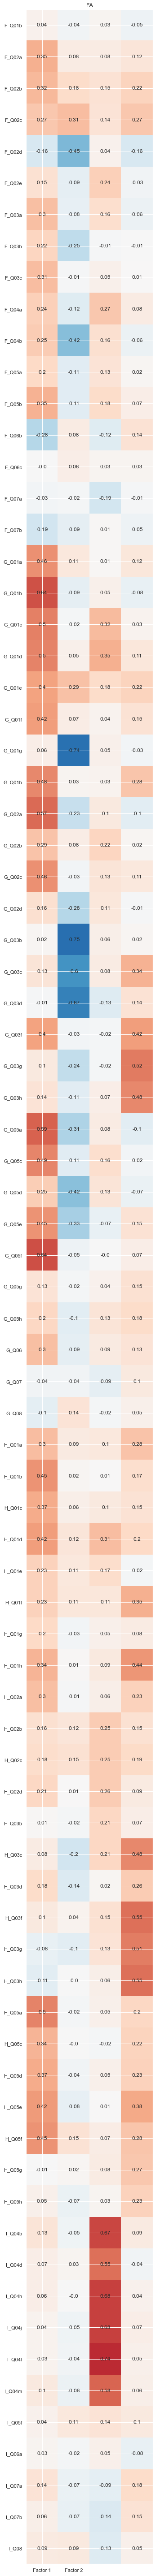

In [646]:
factor_matrix = fa.components_.T
title = "FA"
#  Plot the data as a heat map
fig, ax = plt.subplots(figsize=(100, 80))
im = ax.imshow(factor_matrix, cmap="RdBu_r", vmax=1, vmin=-1)
    #  and add the corresponding value to the center of each cell
for (i,j), z in np.ndenumerate(factor_matrix):
    ax.text(j, i, str(z.round(2)), ha="center", va="center")
    #  Tell matplotlib about the metadata of the plot
ax.set_yticks(np.arange(len(tofactor.columns)))
if ax.get_subplotspec().is_first_col():
    ax.set_yticklabels(tofactor.columns)
else:
    ax.set_yticklabels([])
ax.set_title(title)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Factor 1", "Factor 2"])
#  and squeeze the axes tight, to save space
plt.tight_layout()
    
#  and add a colorbar
#  show us the plot
plt.show()

In [639]:
get_variable_desc(trial, tofactor)

var  \
0   F_Q01b   
1   F_Q02a   
2   F_Q02b   
3   F_Q02c   
4   F_Q02d   
5   F_Q02e   
6   F_Q03a   
7   F_Q03b   
8   F_Q03c   
9   F_Q04a   
10  F_Q04b   
11  F_Q05a   
12  F_Q05b   
13  F_Q06b   
14  F_Q06c   
15  F_Q07a   
16  F_Q07b   
17  G_Q01a   
18  G_Q01b   
19  G_Q01c   
20  G_Q01d   
21  G_Q01e   
22  G_Q01f   
23  G_Q01g   
24  G_Q01h   
25  G_Q02a   
26  G_Q02b   
27  G_Q02c   
28  G_Q02d   
29  G_Q03b   
30  G_Q03c   
31  G_Q03d   
32  G_Q03f   
33  G_Q03g   
34  G_Q03h   
35  G_Q05a   
36  G_Q05c   
37  G_Q05d   
38  G_Q05e   
39  G_Q05f   
40  G_Q05g   
41  G_Q05h   
42   G_Q06   
43   G_Q07   
44   G_Q08   
45  H_Q01a   
46  H_Q01b   
47  H_Q01c   
48  H_Q01d   
49  H_Q01e   
50  H_Q01f   
51  H_Q01g   
52  H_Q01h   
53  H_Q02a   
54  H_Q02b   
55  H_Q02c   
56  H_Q02d   
57  H_Q03b   
58  H_Q03c   
59  H_Q03d   
60  H_Q03f   
61  H_Q03g   
62  H_Q03h   
63  H_Q05a   
64  H_Q05c   
65  H_Q05d   
66  H_Q05e   
67  H_Q05f   
68  H_Q05g   
69  H_Q05h   
70  I_Q04b   
71  I_Q04d   
72  I_Q04h   
73  I_Q04j   
74  I_Q04l   
75  I_Q04m   
76  I_Q05f   
77  I_Q06a   
78  I_Q07a   
79  I_Q07b   
80   I_Q08   

                                                                                                   desc  
0                                                     Skill use work - Time cooperating with co-workers  
1                                                Skill use work - How often - Sharing work-related info  
2                                                          Skill use work - How often - Teaching people  
3                                                            Skill use work - How often - Presentations  
4                                                                  Skill use work - How often - Selling  
5                                                          Skill use work - How often - Advising people  
6                                                  Skill use work - How often - Planning own activities  
7                                               Skill use work - How often - Planning others activities  
8                                                      Skill use work - How often - Organising own time  
9                                                       Skill use work - How often - Influencing people  
10                                                 Skill use work - How often - Negotiating with people  
11                                                   Skill use work - Problem solving - Simple problems  
12                                                  Skill use work - Problem solving - Complex problems  
13                                      Skill use work - How often - Working physically for long period  
14                                                  Skill use work - How often - Using hands or fingers  
15                                                               Skill use work - Not challenged enough  
16                                                                  Skill use work - Need more training  
17                                          Skill use work - Literacy - Read directions or instructions  
18                                              Skill use work - Literacy - Read letters memos or mails  
19                                             Skill use work - Literacy - Read newspapers or magazines  
20                               Skill use work - Literacy - Read professional journals or publications  
21                                                               Skill use work - Literacy - Read books  
22                                      Skill use work - Literacy - Read manuals or reference materials  
23                                                Skill use work - Literacy - Read financial statements  
24                                         Skill use work - Literacy - Read diagrams maps or schematics  
25                                             Skill use work - Literacy - Write letters memos or mail

In [363]:
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 10000

evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


cv_res = xgb.cv(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   verbose_eval=10, # Every ten rounds
   early_stopping_rounds=50,
   nfold = 5
)

model = xgb.train(params, dtrain_reg, num_boost_round=len(cv_res))

[0]	train-rmse:0.00191+0.00001	test-rmse:0.00193+0.00007
[10]	train-rmse:0.00058+0.00003	test-rmse:0.00066+0.00003
[20]	train-rmse:0.00027+0.00001	test-rmse:0.00036+0.00004
[30]	train-rmse:0.00023+0.00001	test-rmse:0.00033+0.00004
[40]	train-rmse:0.00023+0.00001	test-rmse:0.00033+0.00004
[50]	train-rmse:0.00023+0.00001	test-rmse:0.00033+0.00004
[60]	train-rmse:0.00023+0.00001	test-rmse:0.00033+0.00004
[70]	train-rmse:0.00023+0.00001	test-rmse:0.00033+0.00004
[80]	train-rmse:0.00023+0.00001	test-rmse:0.00033+0.00004
[90]	train-rmse:0.00023+0.00001	test-rmse:0.00033+0.00004
[100]	train-rmse:0.00023+0.00001	test-rmse:0.00033+0.00004
[110]	train-rmse:0.00023+0.00001	test-rmse:0.00033+0.00004
[120]	train-rmse:0.00023+0.00001	test-rmse:0.00033+0.00004
[130]	train-rmse:0.00023+0.00001	test-rmse:0.00033+0.00004
[135]	train-rmse:0.00023+0.00001	test-rmse:0.00033+0.00004


In [ ]:
0.0022

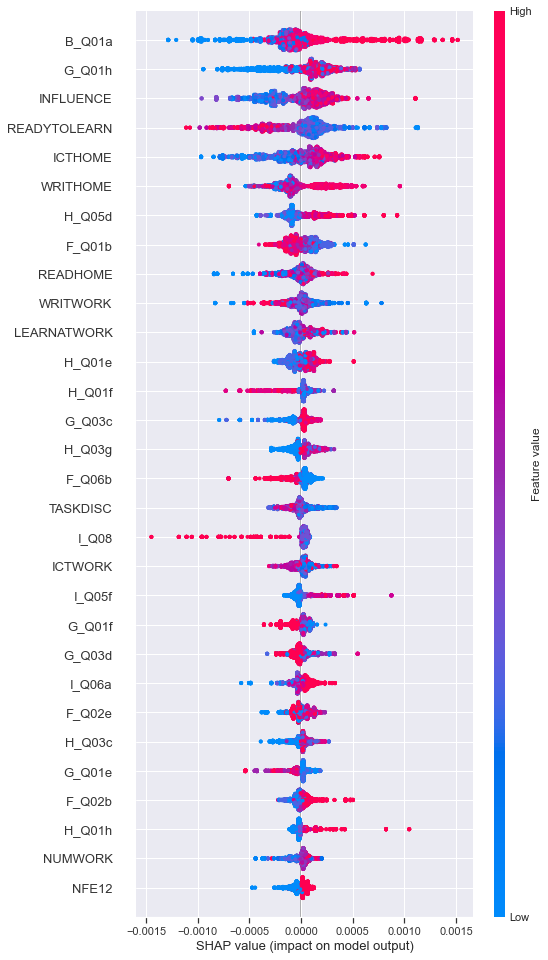

In [436]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display = 30)

In [438]:
get_variable_desc(trial,['G_Q03d','G_Q01e'])

var                                                      desc
0  G_Q03d  Skill use work - Numeracy - How often - Use a calculator
1  G_Q01e                    Skill use work - Literacy - Read books

In [661]:
preds = model.predict(dtest_reg)

rmse = mean_squared_error(y_test, preds, squared=True)
print(f"RMSE of the base model: {rmse:.7f}")

RMSE of the base model: 0.0000001


In [367]:
r2 = r2_score(y_test, preds)
n = len(y_test)
p = len(model.feature_names)
adj_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
adj_r2

0.9818307166032613

### CODE GRAVEYARD


This subsection included assessments and approaches not incorporated in the final calaulations.

Reatined for additional implementations

In [135]:
import seaborn as sns

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import warnings
import xgboost as xgb

complete_columns = total_reg.copy()
warnings.filterwarnings("ignore")
trialxg1 = trial
trialxg1 = trialxg1.sample(frac=1).reset_index(drop=True)
trialxg1['B_Q01a'] = normalize(trialxg1[['B_Q01a']], axis=0)
trialxg1['PVPSL1'] = normalize(trialxg1[['PVPSL1']], axis=0)
X1 = trialxg1['B_Q01a']
y1 = trialxg1['PVPSL1']



X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=1)
dtrain_reg1 = xgb.DMatrix(X_train1, y_train1)
dtest_reg1 = xgb.DMatrix(X_test1, y_test1)


In [138]:
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
n = 10000

evals = [(dtest_reg1, "validation"), (dtrain_reg1, "train")]


cv_res1 = xgb.cv(
   params=params,
   dtrain=dtrain_reg1,
   num_boost_round=n,
   verbose_eval=10, # Every ten rounds
   early_stopping_rounds=50,
   nfold = 5
)

model1 = xgb.train(params, dtrain_reg1, num_boost_round=len(cv_res1))

[0]	train-rmse:0.00218+0.00001	test-rmse:0.00218+0.00004
[10]	train-rmse:0.00209+0.00001	test-rmse:0.00210+0.00003
[20]	train-rmse:0.00209+0.00001	test-rmse:0.00210+0.00003
[30]	train-rmse:0.00209+0.00001	test-rmse:0.00210+0.00003
[40]	train-rmse:0.00209+0.00001	test-rmse:0.00210+0.00003
[50]	train-rmse:0.00209+0.00001	test-rmse:0.00210+0.00003
[60]	train-rmse:0.00209+0.00001	test-rmse:0.00210+0.00003


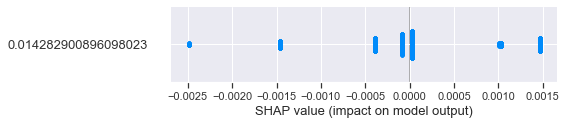

In [139]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model1)
shap_values1 = explainer.shap_values(X_train1)
shap.summary_plot(shap_values1, X_train1)

In [142]:
preds1 = model1.predict(dtest_reg1)

rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")


RMSE of the base model: 0.000


In [143]:
r21 = r2_score(y_test1, preds1)
n1 = len(y_test1)
p1 = len(model1.feature_names)
adj_r21 = 1 - ((1 - r21) * (n1 - 1)) / (n1 - p1 - 1)

In [144]:
adj_r21

0.11722975365882826

In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
def exploratory_regressions(mchk, columns):
    model = LinearRegression()
    results = []
    y = mchk['PVPSL1']
    y = np.log(y)
    l = len(mchk)
    for i in range (4, 5):
        possible_combos = list(combinations(columns, i))
        for j in possible_combos:
            x = mchk[list(j)]
            x = normalize(x, axis=0)
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 9)
            model.fit(x, y)
            y_prediction =  model.predict(x)
            r_sq = model.score(x, y)
            score=r2_score(y,y_prediction)
            #print(f'for variables {j}')
            r2a = 1-(1-score)*(l-1)/(l-i-1)
            #resid = y_prediction - y_test
            #print(f'for the set of variables {j} we get an adhuster-R score of {r2a}')
            #print('mean_sqrd_error is==',mean_squared_error(y_test,y_prediction))

            #print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_prediction)))
            resi = [list(j),r2a]
            results.append(resi)
        retdf = pd.DataFrame(results, columns = ['Variable Combo','R-adjusted'])
    return retdf
                    
exreg1 = exploratory_regressions(final,tc1)

In [251]:
# !pip install factor-analyzer
# Instantiate factor analysis object
from factor_analyzer.factor_analyzer import FactorAnalyzer 
fa = FactorAnalyzer(rotation='varimax')
fa.fit(tofactor)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

ValueError: array must not contain infs or NaNs

In [ ]:
# We obviously have existing collinearities.
# We will run pairwise comparison on our collinear variables, retaining the ones that have the best explainability on their own

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip


def gls_explore(df,cols):
    unilist = []
    print('HEYYY')
    model = LinearRegression()
    y = np.array(df['PVPSL1']).reshape(-1,1)
    y = np.log(y)
    l = len(df)
    for i in cols:
        x = np.array(df[i])#.reshape(-1,1)
#         print(np.shape(x))
        x = sm.add_constant(x)
#         plt.figure(figsize=(8, 4))
#         print(np.shape(x))
#         print(np.shape(y))
#         plt.scatter(x[:,[1]], y)
#         plt.xlabel(f"Predicted Values of {i}")
#         plt.ylabel("Residuals")
#         plt.title("Residuals vs. Predicted Values")
#         plt.show() 
        result = sm.OLS(y, x).fit(cov_type = 'HC3')
        ######## SKLEARN APPROACH THAT WAS NOT PREFFERED ##############
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 9)
        model.fit(x, y)
        y_prediction =  model.predict(x)
        score=r2_score(y,y_prediction) 
        r2a = 1-(1-score)*(l-1)/(l-2)
        unilist.append([i,score])
#         print(f"Scikit Results: var = {i} and R-adj{score}")
#         print("              ")
#         print(f" STATS RESULTS FOR VARIABLE {i}")
        print(result.summary())
        pred_val = result.fittedvalues.copy()
        true_val = df[i].values.copy()
        #residual = true_val - pred_val
        import statsmodels.stats.api as sms
        print("TEST111111")
        print(sms.linear_rainbow(result))
        print("TEST2222222222")
        print(sms.het_goldfeldquandt(y,x))
        print("TEST33333333333222")
        from statsmodels.stats.diagnostic import het_breuschpagan
        bp_test = het_breuschpagan(result.resid, result.model.exog)
        print("Breusch-Pagan test p-value:", bp_test[1])
        print("#The est666666666666666")
        white_test = het_white(result.resid,  result.model.exog)
        #Zipping the array with labels
        names = ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
        print(white_test[1].round(4))
        print(lzip(names,white_test))
        print(white_test)
    unidf = pd.DataFrame(unilist,columns = ['Variable','R'])
    return unidf
colss = ['I_Q06a',['B_Q01a', 'INFLUENCE', 'G_Q04', 'I_Q06a']]
yy = []
yy.append(tc1.copy())
unidf = gls_explore(final,yy)

In [ ]:
# We obviously have existing collinearities.
# We will run pairwise comparison on our collinear variables, retaining the ones that have the best explainability on their own

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip


def univar_reg_explore3(df,cols):
    unilist = []
    model = LinearRegression()
    y = np.array(df['PVPSL1']).reshape(-1,1)
    l = len(df)
    for i in cols:
        try:
            print(i)
            x = np.array(df[i]).reshape(-1,1)
            x = normalize(x, axis=0)
            x = sm.add_constant(x)
            print(x)
            print("x read")
            result = sm.OLS(y, x).fit(cov_type = 'HC3')
            unilist.append([i ,result.rsquared_adj])
            print("unilist set")
#             ######## SKLEARN APPROACH##############
#             model.fit(x, y)
#             y_prediction =  model.predict(x)
#             score=r2_score(y,y_prediction) 
#             r2a = 1-(1-score)*(l-1)/(l-2)
#             #unilist.append([i,score])
# #                 print(f"Scikit Results: var = {i} and R-adj{score}")
# #                 print("              ")
# #         #         print(f" STATS RESULTS FOR VARIABLE {i}")
# #                 pred_val = result.fittedvalues.copy()
# #                 true_val = df[i].values.copy()
# #                 #residual = true_val - pred_val
#                 print("TEST111111")

            print(f'Rainbow Linearity test returns {sms.linear_rainbow(result)}')
            name = ["t value", "p value"]
            test = sms.linear_harvey_collier(result)
            lzip(name, test)
#            print(f'Harvey Linearity test returns {sms.linear_harvey_collier(result)}')      
            print(f'RESET test returns {sms.linear_reset(result, use_f=True)}')      
            print(f"variable: {i} ")
            print(result.summary())
            sns.set (style = 'darkgrid')
            sns.lmplot (df, x=i,y='PVPSL1')
            plt.title ('Simple Linear Regression')
            plt.xlabel (i)
            plt.ylabel ('score')
            plt.show ()


# #                 print("TEST2222222222")

#             hetero = sms.het_goldfeldquandt(y,x, alternative="two-sided")
#             print(hetero)
# #                 print("TEST33333333333222")
# #             from statsmodels.stats.diagnostic import het_breuschpagan
# #             bp_test = het_breuschpagan(result.resid, result.model.exog)
# #             print("Breusch-Pagan test p-value:", bp_test[1].round(4))
#             print("#The est666666666666666")
#             white_test = het_white(result.resid,  result.model.exog)
#             #Zipping the array with labels
#             names = ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
#             print(white_test[1].round(4))
#             print(lzip(names,white_test))
#             print(white_test)
                
        except Exception as e:
            #print(f"{i} is not included in the dataset, skipping to the next predictor")
            print(e)
            continue
    unidf = pd.DataFrame(unilist,columns = ['Variable','R'])
    return unidf

In [ ]:
from scipy import stats

def univar_reg_detail(df,cols):
    unilist = []
    model = LinearRegression()
    y = np.array(df['PVPSL1']).reshape(-1,1)
    l = len(df)
    for i in cols:
        x = np.array(final[i]).reshape(-1,1)
        x = normalize(x, axis=0)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 9)
        model.fit(x_train, y_train)
        y_prediction =  model.predict(x_test)
        score=r2_score(y_test,y_prediction) 
        r2a = 1-(1-score)*(l-1)/(l-2)
        pval = stats.ttest_ind(x_train, y_train).pvalue
        slope = model.coef_
        residuals = y_test - y_prediction
        mse = mean_squared_error(y_test, y_prediction, squared = False)
        plt.figure(figsize=(8, 4))
        plt.scatter(y_prediction, residuals)
        plt.xlabel(f"Predicted Values of {i}")
        plt.ylabel("Residuals")
        plt.title("Residuals vs. Predicted Values")
        plt.show()
        unilist.append([i,r2a, pval, mse])
        import statsmodels.api as sm

        x_train = sm.add_constant(x_train)
        x_test = sm.add_constant(x_test)

        model1 = sm.OLS(y_train, x_train).fit()
        predictions = model1.predict(x_test) 

        print_model = model1.summary()
        print(print_model)
        
    unidf = pd.DataFrame(unilist,columns = ['Variable','R','pval','mse'])
        
    return unidf

In [ ]:
unidf

In [ ]:
'0124'[0:2]

We replace null values with -100. 

Specific indices get negative values (lowest examined > -2), so we will use -100 as a safety value in order to easily identify nulls

We modify our dataset, in order for the filtered responses to have Plausible values for PSTRE.

This requires two types of modification: 

    1. Filtering out people that opted out of the CBA test 
    2. Assigning 0 to any relevant ICT metric, for people that did not participate due to literacy or ICT experience issues

In [ ]:
len(final)

In [ ]:
final.groupby('C_Q01c', dropna = False).count()['CNTRYID']

In [ ]:
#We only keep employed, due to larger variables availability based on work tasks & job content

employed = chk[chk['C_D05'].isin([1,2])]

In [ ]:
get_values('C_D05')

PBROUTE includes alternative test routes, meaning whether they were assigned a computer test, or why they weren't

In [ ]:
employed.groupby('PBROUTE').count()['CNTRYID']

In [ ]:
get_values('PBROUTE')

We will be filtering out respondents who refused CBA, since we cannot assign values of PSTRE

At the same time, we will assign zero values to all PSTRE PVs for anyone who failed ICT Core or claimed no experience.

It is safe to assume that those alternatives go along with no PSTRE proficiency at all, since respondents cannot act in digit. env

We need to see what happened with respondents of null status & uncategorized status. We will combine it with the PSLSTATUS

In [ ]:
len(employed[employed['PBROUTE']==-100])

In [ ]:
get_values('PSLSTATUS')

In [ ]:
employed = employed[employed['PBROUTE'].isin([-100,1,2,4])]
#Let's check now, what is the status of PVs for the employed dataset
employed[['PBROUTE','PSLSTATUS']].drop_duplicates()

In [ ]:
employed.groupby(['PBROUTE','PSLSTATUS']).mean('PSLPV1')

In [ ]:
#We will keep the ones that were not categorized in the PBROUTE, but have PVs calculated.
#We will drop the ones that are not categorized to PBROUTE and do not have PV calculated
employed = employed[~((employed['PBROUTE']==-100) & (employed['PSLSTATUS']==-100))]

In [ ]:
#Now that we have our complete dataset, we will split our categories in themes and check what their correlation is
#This is to assess if they are all required or we can filter some out

In [ ]:
activity_cols = ['LEARNATWORK',
'READYTOLEARN',
'ICTHOME',
'ICTWORK',
'INFLUENCE',
'NUMHOME',
'NUMWORK',
'PLANNING',
'READHOME',
'READWORK',
'TASKDISC',
'WRITHOME',
'WRITWORK']

In [ ]:
# import seaborn as sns
# sns.pairplot(employed[activity_cols])

In [ ]:

activity_cols = ['LEARNATWORK',
'READYTOLEARN',
'ICTHOME',
'ICTWORK',
'INFLUENCE',
'NUMHOME',
'NUMWORK',
'PLANNING',
'READHOME',
'READWORK',
'TASKDISC',
'WRITHOME',
'WRITWORK']

In [ ]:
#In order to depict complete lack of ITC interraction, we create a new scale level 0 for ICT @ work sub-indices & synthetic index

#We have additionally assigned to this level individuals that were not provided an ICT@ work index, but stated level 1 at all sub-indeces
#Lastly, we assign to this level individuals that state scale 1to all, apart from coding language where they stated 5 - highly unlikely & considered invalid

#This will also allow for easier differentiation on analyses using the actual observed IT interraction sample
#In the same spirit, we assign a 0 scale value to the ICT@HOME_WLE_CA

In [ ]:
import numpy as np
workictvars = ['G_Q05a', 'G_Q05c','G_Q05d','G_Q05e','G_Q05f','G_Q05g','G_Q05h','ICTWORK', 'ICTWORK_WLE_CA']

mask = (employed['G_Q04'] == 2)


employed.loc[mask, workictvars] = 0

maskw = (employed['ICTWORK'] == -1)
employed.loc[maskw, 'ICTWORK'] = 0

maskw1 = (employed['ICTWORK'] == 0)
employed.loc[maskw1, 'ICTWORK_WLE_CA'] = 0

In [ ]:
employed.loc[mask, workictvars].sort_values(by = ['ICTWORK_WLE_CA','G_Q05a']).head(300)

In [ ]:
#Accordingly, we do the exact same assignments for ICT@ home (sub) indicators

homeictvars = ['H_Q05a', 'H_Q05c','H_Q05d','H_Q05e','H_Q05f','H_Q05g','H_Q05h', 'ICTHOME_WLE_CA', 'ICTHOME']

maskh = ((employed['H_Q04a'] == 2) | (employed['H_Q04b'] == 2))

homeictvars1 = ['H_Q05a', 'H_Q05c','H_Q05d','H_Q05e','H_Q05f','H_Q05g','H_Q05h', 'ICTHOME_WLE_CA', 'H_Q04a','H_Q04b']

employed.loc[maskh, homeictvars] = 0

#mask = (employed['ICTWORK'] == -1)
#employed.loc[mask, 'ICTWORK'] = 0
#homeictvars1.append(['H_Q04a','H_Q04b'])
employed.groupby(homeictvars1).count()['CNTRYID'].reset_index().sort_values(by='ICTHOME_WLE_CA')

In [ ]:
employed.groupby('WRITWORK_WLE_CA').count().reset_index()

In [ ]:
len(employed)

In [ ]:
employed.groupby(['ICTWORK_WLE_CA','G_Q04']).count().reset_index()

In [ ]:
sl1 = ['LEARNATWORK','LEARNATWORK_WLE_CA','READYTOLEARN','READYTOLEARN_WLE_CA','ICTHOME','ICTHOME_WLE_CA',
       'ICTWORK','ICTWORK_WLE_CA','INFLUENCE','INFLUENCE_WLE_CA','NUMHOME','NUMHOME_WLE_CA','NUMWORK',
       'NUMWORK_WLE_CA','PLANNING','PLANNING_WLE_CA','READHOME','READHOME_WLE_CA','READWORK','READWORK_WLE_CA',
       'TASKDISC','TASKDISC_WLE_CA','WRITHOME','WRITHOME_WLE_CA','WRITWORK','WRITWORK_WLE_CA']

In [ ]:
employed.groupby(['READWORK','READWORK_WLE_CA']).count()['CNTRYID']

In [ ]:
employed[employed[selected_cols]==-1].count()

In [ ]:
employed[selected_cols]

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

def exploratory_regressions(mchk, columns):
    model = LinearRegression()
    results = []
    y = mchk['PVPSL1']
    l = len(mchk)
    for i in range (2, len(columns)):
        possible_combos = list(combinations(columns, i))
        for j in possible_combos:
            x = mchk[list(j)]
            x = normalize(x, axis=0)
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 9)
            model.fit(x_train, y_train)
            y_prediction =  model.predict(x_test)
            r_sq = model.score(x, y)
            score=r2_score(y_test,y_prediction)
            print(f'for variables {j}')
            #print('r2 socre is ',score)
            r2a = 1-(1-score)*(l-1)/(l-i-1)

            #print('mean_sqrd_error is==',mean_squared_error(y_test,y_prediction))

            #print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_prediction)))
            print(f"coefficient of determination:  {r2a}")
            


In [ ]:
exploratory_regressions(employed, selected_cols)

In [ ]:
chk[chk['PBROUTE']==5][['PSLSTATUS','PVPSL9','CBA_START']]

No category 5 user has a PSTRE PV score, so we filter them out as well. We proceed to check -1, meaning null PBROUTE responses

In [ ]:
chk[chk['PBROUTE']==-1][['PSLSTATUS','PVPSL9','CBA_START']].sort_values(by=['PSLSTATUS','PVPSL9','CBA_START']).reset_index()

In [ ]:
We have 317 cases without PSTRE PVs, all of which have a PSLSTATUS = 3, meaning unable to  

In [ ]:
chk.groupby('PSLSTATUS').count()['CNTRYID']

In [ ]:
chk.iloc[[392]]

In [ ]:
chk[['PBROUTE','PSLSTATUS','PVPSL9']].sort_values(by=['PSLSTATUS','PBROUTE','PVPSL9']).reset_index()

In [ ]:
chk.groupby('PBROUTE').count()['CNTRYID'].reset_index()

In [ ]:
chk.groupby(['PBROUTE','PSLSTATUS']).count()['CNTRYID'].reset_index()

We identify three cases, with respective variables available for our analysis

1. Currently employed
2. Employable with employment over the past 12 months
3. Total population

In [ ]:
employed = chk[chk['C_D09']==1]

In [ ]:
chk.groupby('PBROUTE').count()

In [ ]:
chk[chk['C_D05']==2]

In [ ]:
retired = ever_employed[ever_employed['C_Q07']==6]

In [ ]:
get_values('C_Q03_04')

In [ ]:
retired[retired['C_D08c'].isna()]

In [ ]:
retired[['C_D08c','C_Q10a']].drop_duplicates()

In [ ]:
chk.groupby(['C_Q07','C_D08c']).count()['CNTRYID']

In [ ]:
p12mempl = 

In [ ]:
1/(sum(chk['SPFWT0'])/sum(chk[chk['PBROUTE']==3]['SPFWT0']))

In [ ]:
chk[['PSLSTATUS','PVLIT1']].drop_duplicates().sort_values(by='PSLSTATUS')

In [ ]:
1/(sum(chk['SPFWT0'])/sum(chk[chk['C_D09']==3]['SPFWT0']))

In [ ]:
chk.groupby('PSLSTATUS').sum()[''.reset_index()

In [ ]:
for i in chk.columns:
    print(meta.variable_value_labels.get(i))

In [ ]:
employable = chk[chk['C_D09'].isin([1,2])|chk['C_D08c']==1]

In [ ]:
meta.variable_value_labels.get('F_Q07a')

In [ ]:
chk.groupby('C_D08c').count()['CNTRYID']

In [ ]:
#######################################################################
#    TEST FOR DIAGONAL MULTIPLICATION OF WEIGHTS BEFORE MODELING    #
#######################################################################
# Create a diagonal weight matrix W
tW = np.diag(np.array(final['SPFWT0']).flatten())

# Multiply X with W
tX = final[first_reg] @ tW
tY = final['PVPSL1'] @ tW

tX.head(2)

In [ ]:
chk.groupby(['B_Q01a','EDLEVEL3']).count()['CNTRYID'].reset_index()

In [ ]:
meta.column_names_to_labels[]

In [ ]:
chk.groupby('C_D05').count()['CNTRYID']

In [ ]:
meta.variable_value_labels.get('VARSTRAT')

In [ ]:
chk.groupby(['B_Q01a3','ISCED_HF']).count()['CNTRYID']

In [ ]:
chk.groupby('PSLSTATUS').sum()['SPFWT0']

In [ ]:
chk[['PSLSTATUS','PVNUM1','PVNUM2','PVNUM3']].drop_duplicates().sort_values(by='PSLSTATUS')

In [ ]:
import re
pattern = r'[FGHI]_Q0\d[a-zA-Z]?$'
activity_cols = [item for item in chk.columns if re.match(pattern, item)]

In [ ]:
chk.select_dtypes(np.number).columns

In [ ]:
mchk = chk[chk.select_dtypes(np.number).columns].mul(chk['SPFWT0'], axis=0)

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

def exploratory_regressions(columns):
    model = LinearRegression()
    results = []
    y = mchk['PVPSL1']
    l = len(mchk)
    for i in range (2, 3):#len(columns)):
        possible_combos = list(combinations(columns, i))
        for j in possible_combos:
            x = mchk[list(j)]
            x = normalize(x, axis=0)
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 9)
            model.fit(x_train, y_train)
            y_prediction =  model.predict(x_test)
            r_sq = model.score(x, y)
            score=r2_score(y_test,y_prediction)
            print(f'for variables {j}')
            print('r2 socre is ',score)
            r2a = 1-(1-score)*(l-1)/(l-i-1)

            print('mean_sqrd_error is==',mean_squared_error(y_test,y_prediction))

            print('root_mean_squared error of is==',np.sqrt(mean_squared_error(y_test,y_prediction)))
            #print(f"coefficient of determination:  {r_sq}")
            


In [ ]:
selected_cols = ['LEARNATWORK',
'READYTOLEARN',
'ICTHOME',
'ICTWORK',
'INFLUENCE',
'NUMHOME',
'NUMWORK',
'PLANNING',
'READHOME',
'READWORK',
'TASKDISC',
'WRITHOME',
'WRITWORK']

In [ ]:
pattern1 = r'.*WORK$'
selected_cols = [item for item in chk.columns if re.match(pattern1, item)]

In [ ]:
employable1

In [ ]:
selected_cols

In [ ]:
testchk = chk[chk[selected_cols].isna().any(axis=1)].groupby('PAIDWORK5').count()[selected_cols]

In [ ]:
employable1[employable1['PBROUTE']==4][activity_cols].isnull().sum()

In [ ]:
#testchk[['LEARNATWORK', 'ICTWORK', 'NUMWORK', 'READWORK', 'WRITWORK']].drop_duplicates()

In [ ]:
exploratory_regressions(activity_cols)

In [ ]:
#education levels = ['highest completed', 'highest current','highest P12M']
education = ['B_Q01a','B_Q02a','B_Q05a']
education_domain = ['B_Q01b','B_Q02c','B_Q05b']



In [ ]:
chk[['Education - Highest qualification - Area of study','Education - Formal qualification - Area of study','Country ID (ISO 3166, numeric)']].groupby(by=['Education - Highest qualification - Area of study']).count()

In [ ]:
chk = chk.rename(columns = meta.column_names_to_labels)

In [ ]:
chk.groupby(dsplcol).count()

Data Cleaning #1

We filter complete responses

In [ ]:
chk = chk[chk['Final disposition code for person - combining CI and BQ/JRA (derived)']=="Complete"]
chk = chk[chk['Final disposition code for person for Main task instrument, including reading components (derived)']=="Complete"]

In [ ]:
len(chk[chk['DISP_CIBQ']==7])

In [ ]:
chk['DISP_CIBQ'].unique()

Educational manipulation:
    Out of the 3500 respondents, 50 acquired their degree abroad.
    We disregard this parameter, and map the foreign degrees to their Greek equivalent, in order to unify educational levels based on ISCED

In [ ]:
chk['Education - Highest qualification - Level'] = np.where(chk['Education - Highest qualification - Level']=='Foreign qualification', 'Education - Highest qualification - Level of foreign qualification' , chk['Education - Highest qualification - Level'])
display(chk[dsplcol].unique())

In [ ]:
df, metadf = prs.read_sav("C:/Users/alevizos.i/Downloads/ELSTAT Data - Thesis/2022c_users.sav")

In [ ]:
import pandas as pd
import numpy as np
import sklearn

# Simulate a dataset with independent variables (X) and multiply imputed dependent variable (y)
n_samples = 100
n_features = 5
n_imputations = 5

# Create independent variables
X = np.random.rand(n_samples, n_features)

# Create imputed values for y in multiple datasets
imputed_ys = []
for _ in range(n_imputations):
    imputed_y = np.random.normal(0, 1, n_samples)
    imputed_ys.append(imputed_y)

# Perform PCA on each imputed dataset for X
pca_results = []
for imputed_y in imputed_ys:
    pca = PCA(n_components=n_features)
    principal_components = pca.fit_transform(X)
    pca_results.append(principal_components)

# Explore the PCA results across imputations
for i, principal_components in enumerate(pca_results):
    print(f"Principal Components for Imputed Y-{i + 1}:")
    print(principal_components)

# Calculate and explore the variability across imputations
pca_mean = np.mean(pca_results, axis=0)
pca_std = np.std(pca_results, axis=0)

print("Mean Principal Components Across Imputations:")
print(pca_mean)

print("Standard Deviation of Principal Components Across Imputations:")
print(pca_std)

In [ ]:
immigrants = df.replace('Γεννήθηκε στη χώρα και δεν έζησε ποτέ στο εξωτερικό για διάστημα τουλάχιστον 1 έτους','0').reset_index()
immigrants = immigrants[immigrants['YEARESID']!='Δεν απάντησαν'].reset_index()
immigrants = immigrants[immigrants['YEARESID']!='Λιγότερο από 1 έτος στη χώρα, αλλά με πρόθεση να μείνει τουλάχιστον 1 έτος συνολικά'].reset_index(drop=True)
immigrants['YEARESID'] = immigrants['YEARESID'].astype(str).astype(float)

In [ ]:
unempl_imm = immigrants
unempl_imm = unempl_imm[unempl_imm['RDURUNE'] != ""]
unempl_imm = unempl_imm.replace('Λιγότερο από 6 μήνες','0.5').reset_index(drop = True)

In [ ]:
post_df

We calculate the digital intensity (named dii after digital intensity index) of those groups, by calculating the percentage of digital skills they include

We will now use the broad categories we have in our dataframe, as narrow terms for the calculation of the next abstraction level
The digital intensity for groups containing groups, will be the percentage of their 

In [ ]:
#Creation of dictionary for column renames
labels = pd.read_csv('C:/Users/alevizos.i/Downloads/label_data1.csv', header=None, sep=';')
test_keys = labels[1].tolist()
test_values = labels[0].tolist()
res = {}
for key in test_keys:
    for value in test_values:
        res[key] = value
        test_values.remove(value)
        break
res['Q_G5_5']=' QG5 Δεν παρακολούθησα κάποιο πρόγραμμα.'
res['Q_G5_6']=' Q_G5. Δεν γνωρίζω / Δεν απαντώ'
res['DEGURBA']=' Βαθμός αστικοποίησης'
res['RDURUNE']='Διάρκεια ανεργίας κατά Eurostat (DURUNE)'


In [ ]:
#df = df.rename(columns=res)
display(df)

In [ ]:
df[['RQ_C3']].drop_duplicates()

In [ ]:
skills2x2 = skills2x2.rename(columns={"Unnamed: 1": "Occupation"})
skills2x2

In [ ]:
metadf.variable_value_labels

In [ ]:
df.groupby(['Χώρα διαμονης προτού εγκατασταθούν στην Ελλάδα','Απασχόληση σε ευκαιριακή εργασία']).count()

In [ ]:
check = pd.read_csv('Downloads/prgnorp1.csv', low_memory=False)

In [ ]:
check[0:2]

In [ ]:
check['E_Q01a'].unique()

In [ ]:
list(check.columns)